In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))



/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM



In [4]:
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
! pwd

Not using a high-RAM runtime
/content


In [ ]:
%%shell
jupyter nbconvert --to html ///content/Dec22_Murat_Goksenin_Guzel_Project6_v1_1.ipynb

# AllLife Bank Customer Segmentation


### Background and Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. 

They have been advised by their marketing research team, that the penetration in the market can be improved. 

Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. 

Another insight from the market research was that the customers perceive the support services of the back poorly. 

Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. 


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Dictionary
`Sl_No`: Primary key of the records

`Customer Key`:Customer identification number

`Average Credit Limit`: Average credit limit of each customer for all credit cards

`Total credit cards`: Total number of credit cards possessed by the customer

`Total visits bank`: Total number of visits that customer made (yearly) personally to the bank

`Total visits online`: Total number of visits or online logins made by the customer (yearly)

`Total calls made`: Total number of calls made by the customer to the bank or its customer service department (yearly)



## 1-LOADING LIBRARIES

In [ ]:
!pip install nb_black

In [6]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA


# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

##2-LOADING AND EXPLORING DATA

- Loading Data Form CSV

In [8]:
Row_Data = pd.read_csv("https://raw.githubusercontent.com/muratgguzel/AIML-Unsupervised_Learning_Project6-AllLifeBankCustomerSegmentation-CreditCardsChurnPrediction/main/CreditCardCustomerData.csv?token=GHSAT0AAAAAACCXEYFDAVYX3QP42MYD5GUGZDGKIYA")

- Copying row data for working

In [9]:
# copying data to another variable to avoid any changes to original data
data = Row_Data.copy()

 View the first and last 5 rows of the dataset.

In [10]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


- Understand the shape of the dataset.

In [11]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")  

There are 660 rows and 7 columns.


The dataset has 660 rows and 7 columns 

 - Check data format

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


Data set consist of integer values 

Check any null data exits

In [13]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [14]:
num_missing = data.isnull().sum(axis=1)
num_missing.value_counts()

0    660
dtype: int64

In [15]:
round(data.isnull().sum() / data.isnull().count() * 100, 2)

Sl_No                  0.0
Customer Key           0.0
Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
dtype: float64

No missing data exits in data set

Check for Dublicated Data

In [16]:
data[data.duplicated()].count()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No duplicated data exits

**2.1** **Observations About Data**

In [17]:
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


The dataset has `660` rows and `7` columns exits

No missing data exits on data set

No duplicated data exits on data set





**2.2** **Statistical Observations**

`Sl_No`: Primary key of the records

`Customer Key`:Customer identification number

`Average Credit Limit`: %50 of average credit limit is 10000 USD having minimum 3000 and maximum 200000

`Total credit cards`:%50 of customers have 5 or less credir cards with having  value of minimum is 1 , maximum value is 10

`Total visits bank`: %50 of customers visit bank 2 or less annually. Minimum visit is 0 and maximum is 5

`Total visits online`: %50 number of visits or online logins made by the customer (yearly) is 2 having minimum 0 , maximum 15

`Total calls made`: %50 of total number of calls made by the customer to the bank or its customer service department (yearly) is 3 . %25 is equal of less than 1 , %75 is equal or less than 5

In [18]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


Print data values generalization behaviour

In [19]:
print(data.Avg_Credit_Limit.value_counts())
print(data.Total_Credit_Cards.value_counts())
print(data.Total_visits_bank.value_counts())
print(data.Total_visits_online.value_counts())
print(data.Total_calls_made.value_counts())








8000      35
6000      31
9000      28
13000     28
19000     26
10000     26
11000     24
7000      24
14000     23
18000     23
17000     23
16000     22
5000      21
20000     20
12000     18
15000     17
36000     11
70000     10
50000      8
38000      8
68000      7
39000      7
56000      7
41000      6
47000      6
52000      6
48000      6
74000      6
37000      6
30000      6
34000      6
65000      5
26000      5
29000      5
31000      5
60000      5
69000      4
51000      4
66000      4
33000      4
49000      4
71000      4
73000      4
59000      4
64000      4
54000      4
28000      3
57000      3
62000      3
100000     3
45000      3
58000      3
46000      3
44000      3
40000      3
72000      3
61000      3
67000      3
27000      2
32000      2
156000     2
84000      2
163000     2
172000     2
195000     2
42000      2
166000     2
75000      2
63000      2
35000      2
153000     1
184000     1
123000     1
173000     1
144000     1
97000      1
98000      1

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


##3-EXPLOTARY DATA ANALYSIS

Define Categorical Columns vrs Numerical Columns for EDA Analyzes

In [21]:
numerical_cols = [
    "Avg_Credit_Limit",
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made",
    ]

- For EDA analyzes data_EDA dataframe is forming

In [22]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [23]:
data_EDA=data.copy()

**3.1** **UNIVARITY ANALYZES**

In [24]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data:    dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

**3.1.1** **CHECKING AVERAGE CREDIT LIMIT**

In [25]:
data_EDA.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


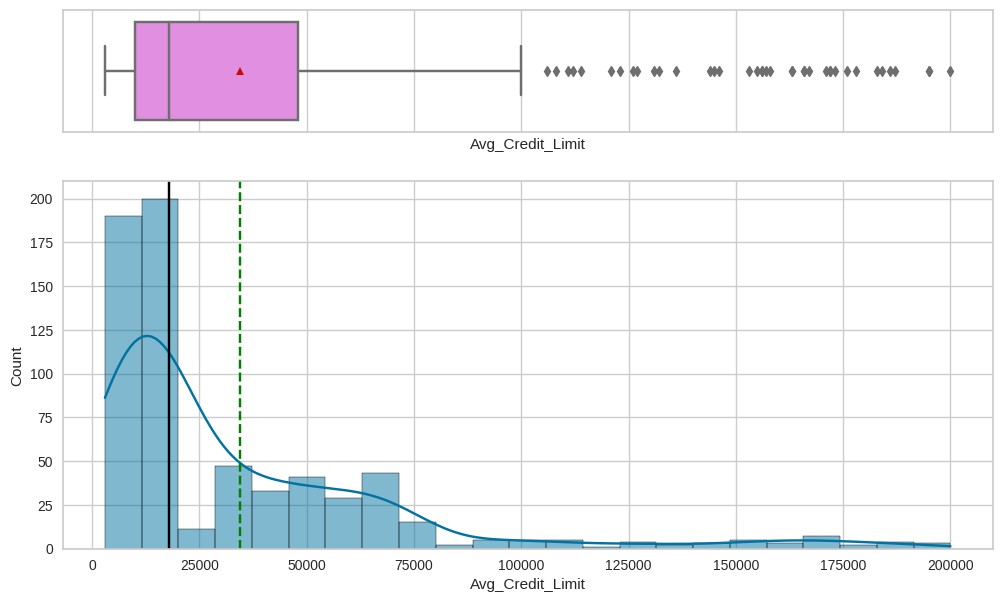

In [26]:
histogram_boxplot(data_EDA,"Avg_Credit_Limit",kde=True)

In [27]:
data_EDA["Avg_Credit_Limit"].median()


18000.0

In [28]:
data_EDA["Avg_Credit_Limit"].mean()

34574.242424242424

- Average Credit Limit Median=18000 USD and Mean=34574 having outliers. Data is Right skewed 

**3.1.2** **CHECKING Total Credit Cards**

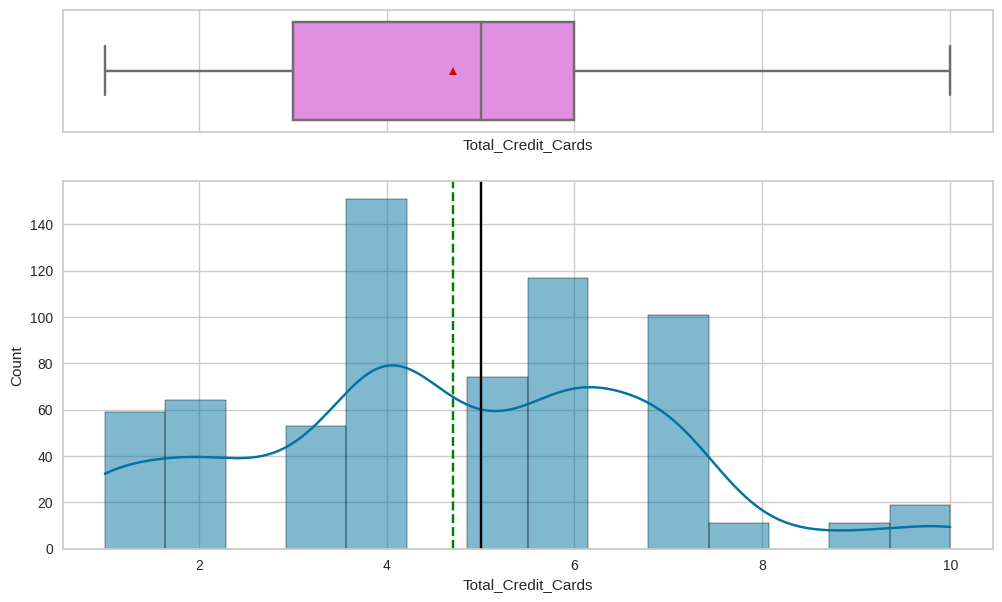

In [29]:
histogram_boxplot(data_EDA,"Total_Credit_Cards",kde=True)

Total_Credit_Cards having Mean = 4.7 and Median=5 which is close to each other. There is no outliers exits in data set




In [30]:
data_EDA["Total_Credit_Cards"].mean()

4.706060606060606

In [31]:
data_EDA["Total_Credit_Cards"].median()

5.0

**3.1.3** **CHECKING Total Visits Bank**

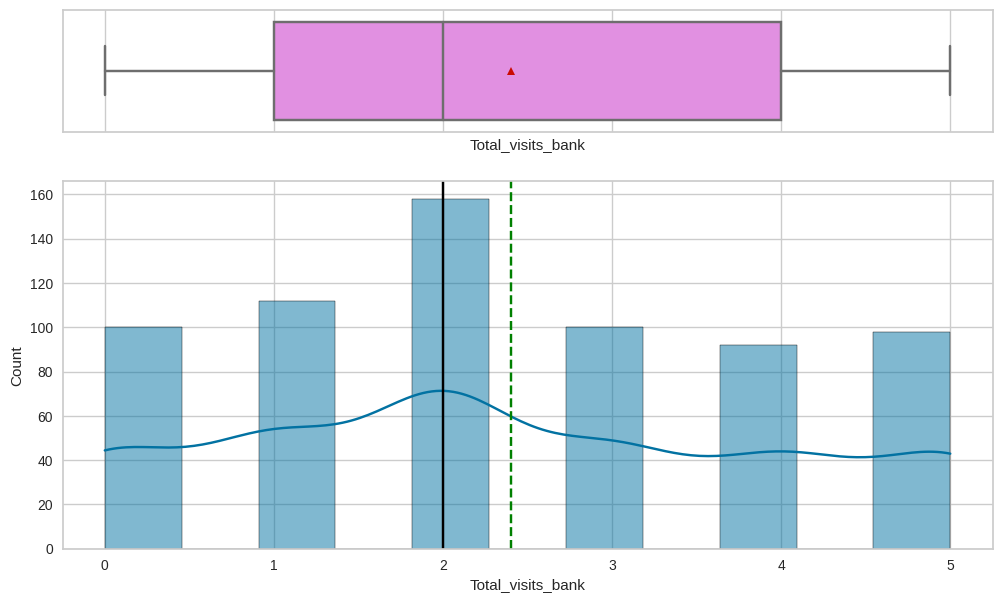

In [32]:
histogram_boxplot(data_EDA,"Total_visits_bank",kde=True)

Total_visits_bank having Mean = 2.4 and Median=2 which is close to each other. There is no outliers exits in data set

In [33]:
data_EDA["Total_visits_bank"].mean()

2.403030303030303

In [34]:
data_EDA["Total_visits_bank"].median()

2.0

**3.1.4** **CHECKING Total Visits Online**

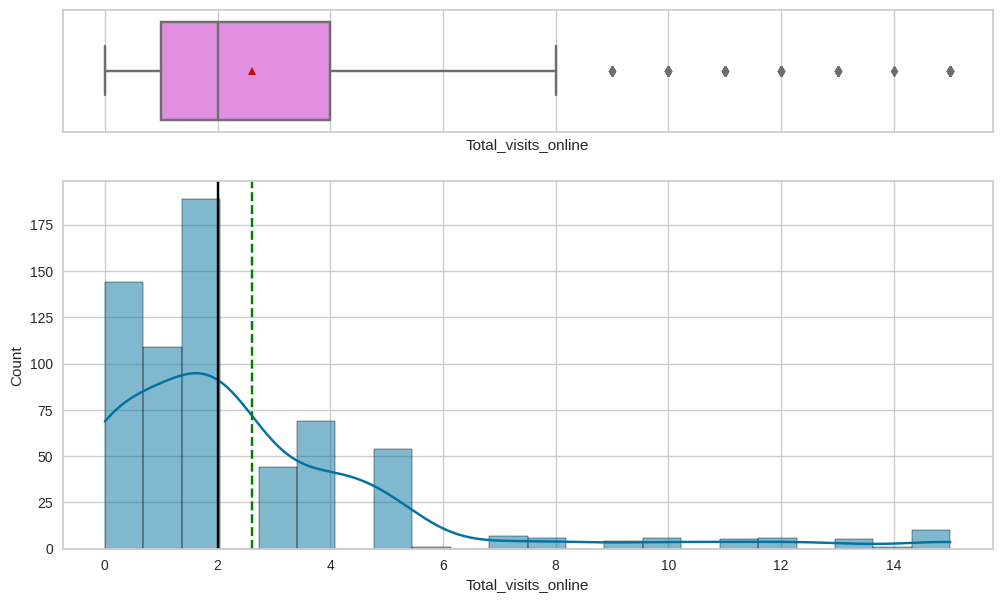

In [35]:
histogram_boxplot(data_EDA,"Total_visits_online",kde=True)

In [36]:
data_EDA["Total_visits_online"].mean()

2.606060606060606

In [37]:
data_EDA["Total_visits_online"].median()

2.0

Total visits online ahs mean:2.6 and median=2.0 which are close to each other. Feature Right skewed and having outliers.

**3.1.5** **CHECKING Total Calls Made**

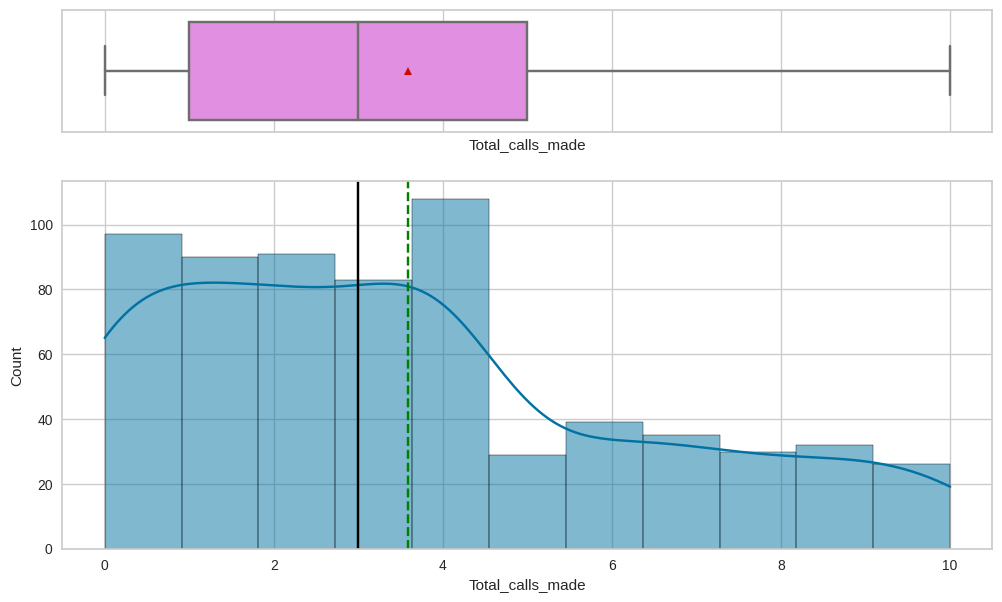

In [38]:
histogram_boxplot(data_EDA,"Total_calls_made",kde=True)

Total_calls_made has mean = 3.58 and median=3 which two data nearly same. No outliers exits at data

In [39]:
data_EDA["Total_calls_made"].mean()

3.5833333333333335

In [40]:
data_EDA["Total_calls_made"].median()

3.0

In [41]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**3.2** **BIVARIATE ANALYSIS**

In [42]:
data_EDA.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


Dropping Customer ID as no need for EDA analyzes

In [43]:
data_EDA = data_EDA.drop(["Sl_No"], axis=1)

In [44]:
data_EDA = data_EDA.drop(["Customer Key"], axis=1)

In [45]:
data_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


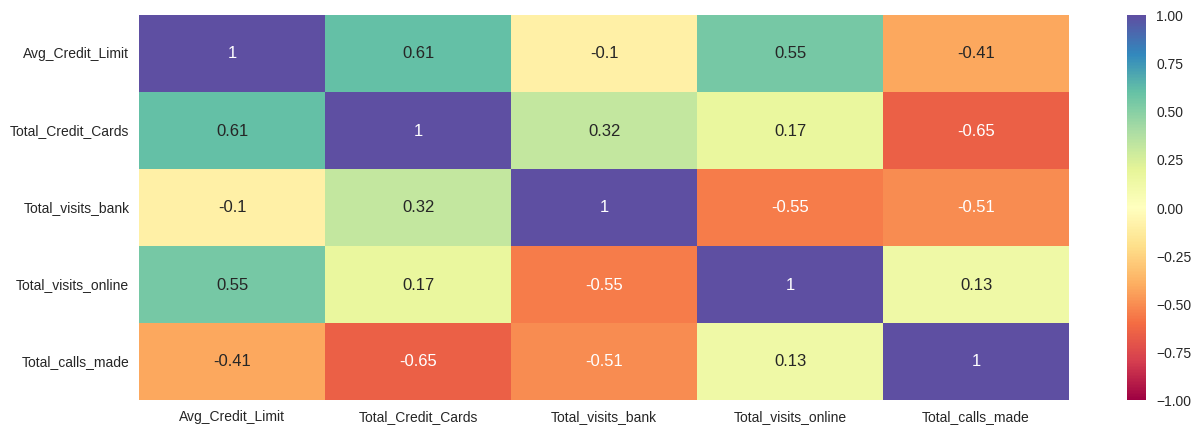

In [46]:
plt.figure(figsize=(15,5))
sns.heatmap(data_EDA.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

**OBSERVATIONS**



*`Average Credit Limit` has a `POSITIVE` Correlation with `Total Credit Cards` , this means that having more credit cards increasing total credit limit 

*`Average Credit Limit` has a `POSITIVE` Correlation with `Total Visits Online`,this means that customers visits more online when they have more credit cards

*`Average Credit Limit` has a `NEGATIVE` Correlation with `Totals Calls Made`,this means that customers who have more Avg Credit Limit less calls . It may be happen due to customers may have more credit cards  calls also other banks channels.

*`Total credit cards` has a `POSITIVE` Correlation with `Total Visits Bank`,this means that customers visits more bank when their card numbers increases

*`Total credit cards` has a `POSITIVE` Correlation with `Total Visits Online`,this means that customers visits more bank online channels when their card numbers increases

*`Total credit cards` has a `NEGATIVE` Correlation with `Total Calls Made`,this means that customers who has more cards can call other banks' channels

*`Total visits bank` has a `NEGATIVE` Correlation with `Total Visits Online`,this means that customers has a preferance of visiting bank rather than using online

*`Total visits bank` has a `NEGATIVE` Correlation with `Total Calls Made`,this means that customers has a preferance of visiting bank rather than using call















**Differentiating Numerical Columns**

In [47]:
numeric_cols = data_EDA.select_dtypes(include=[np.number]).columns

print("Numeric Columns:    ", numeric_cols)

Numeric Columns:     Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')


**All Numerical Columns Analyzsis**

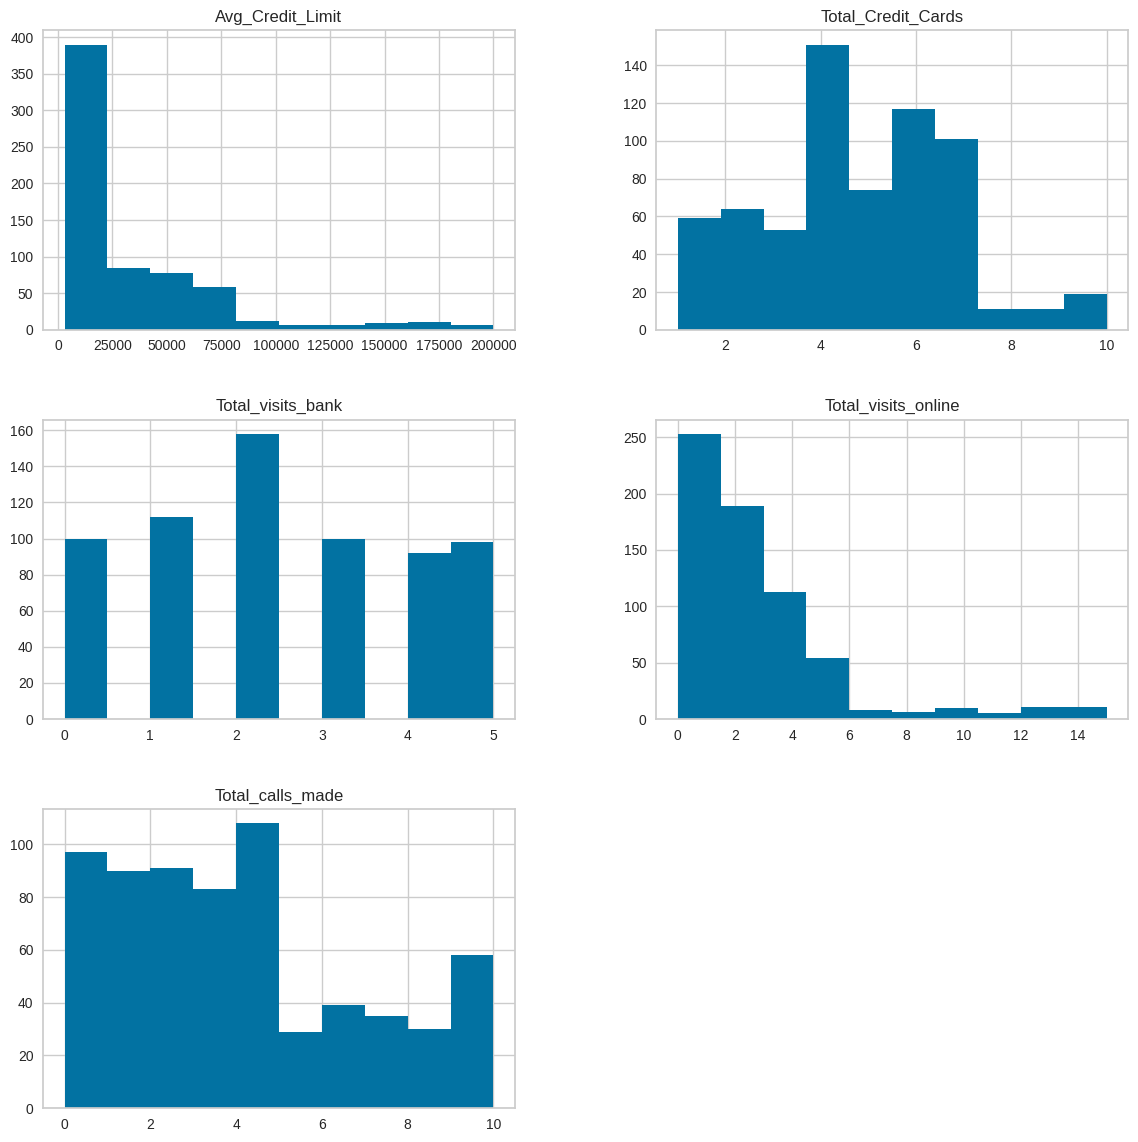

In [48]:
data_EDA[numeric_cols].hist(figsize=(14, 14))
plt.show()

In [49]:
data_EDA.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [50]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

**Avg_Credit_Limit Vrs Total_Credit_Cards**

In [51]:
data_EDA["Total_Credit_Cards"].unique()

array([ 2,  3,  7,  5,  6,  4,  1,  9,  8, 10])

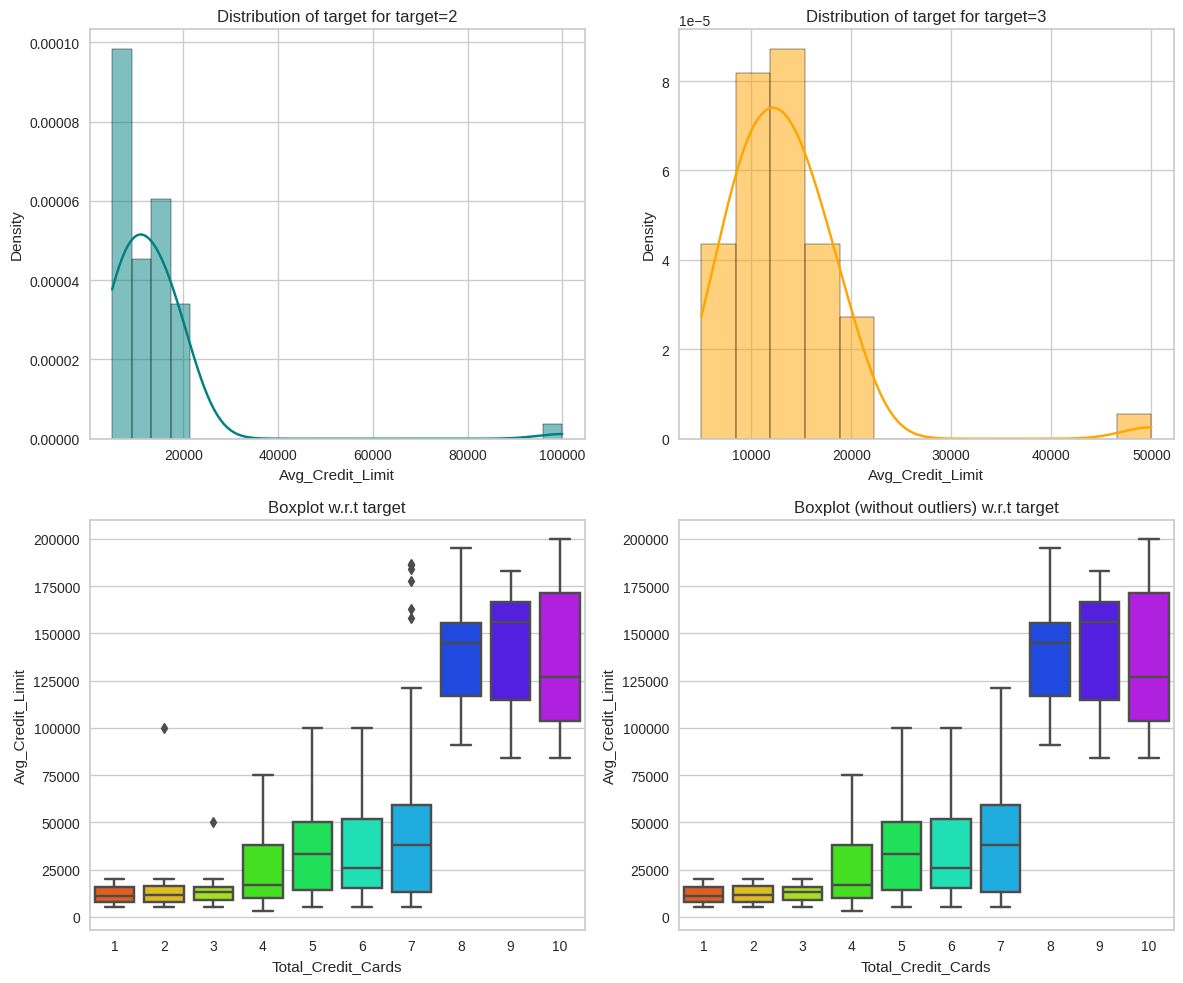

In [52]:
distribution_plot_wrt_target(data_EDA, "Avg_Credit_Limit", "Total_Credit_Cards")

This shows the distribution Average Credit Limit versus Total Credit Cards. Distribution shows bell figure while credit card number increases also this triggers increasing average credit limit. Figure has some outliers which represents credit cards having high credit limit.  After card number 7 high increase seems on Credit Limit.

**Total Credit Cards Versus Total Visits To Bank**

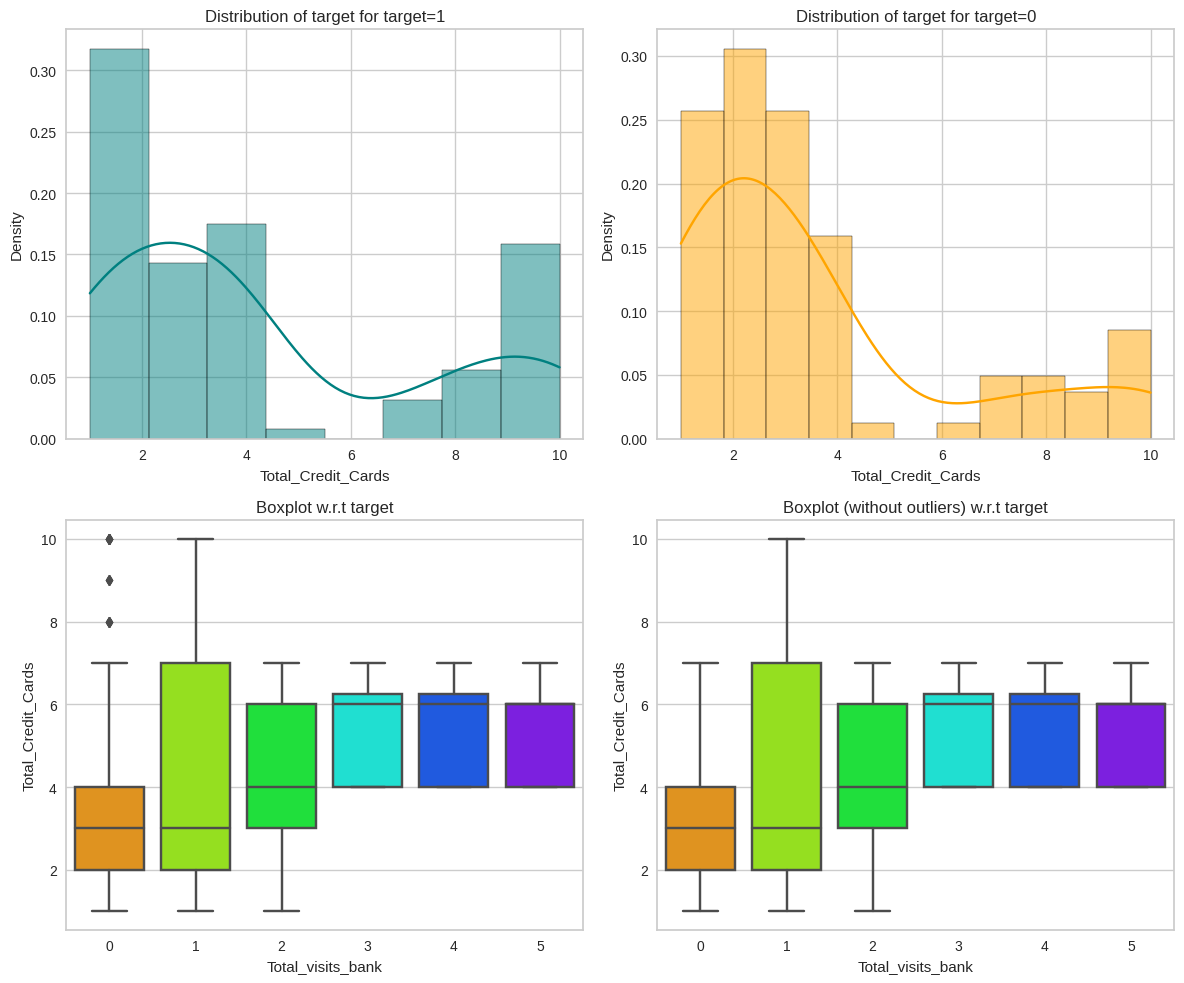

In [53]:
distribution_plot_wrt_target(data_EDA, "Total_Credit_Cards", "Total_visits_bank")

Total credit cards and number of visits to bank has positive correlation. Cards equal to 3 and more shows same pattern visits


In [54]:
#num_col = data_EDA.select_dtypes(include=np.number).columns.tolist()
#for item in num_col:
#    labeled_barplot(data_EDA, item, perc=True)

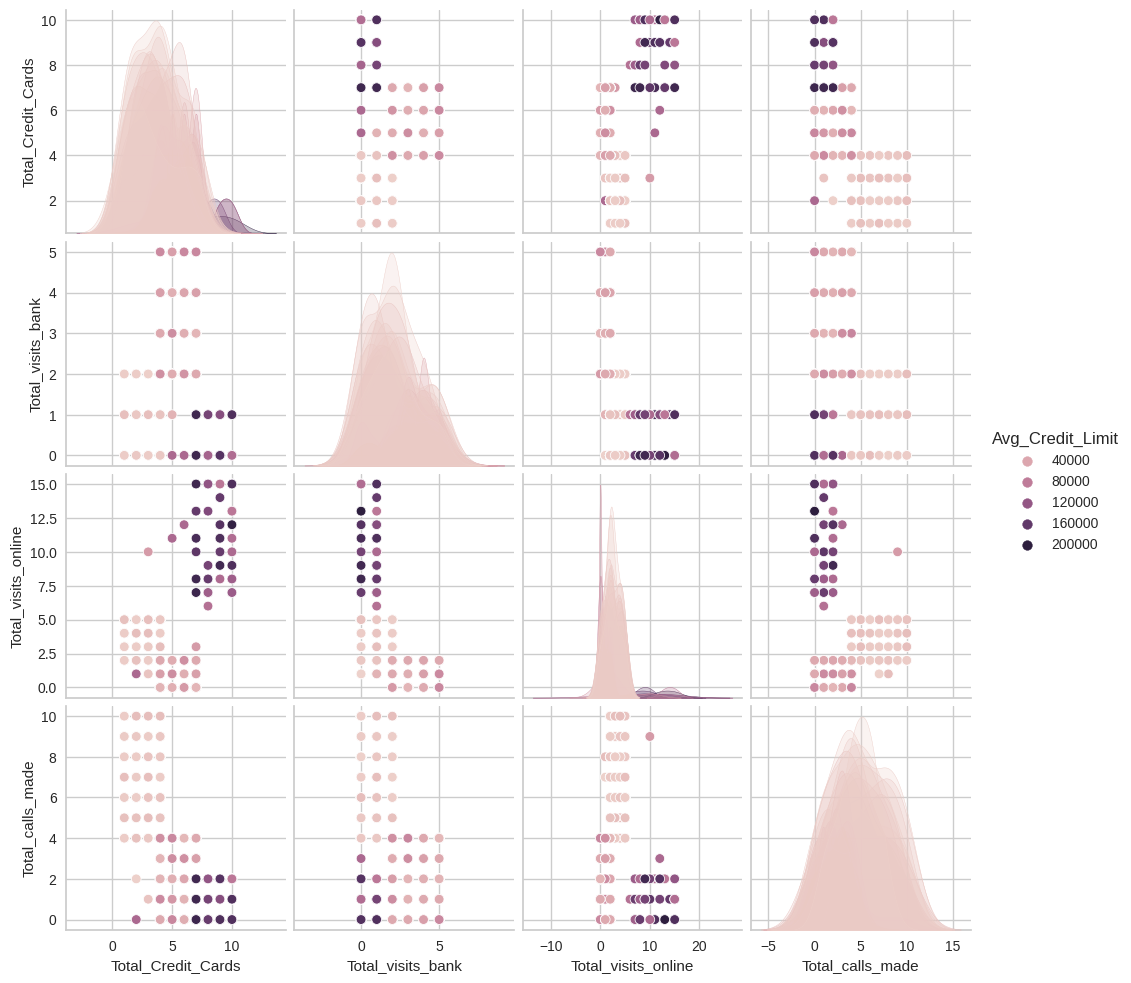

In [55]:
sns.pairplot(data=data_EDA,hue="Avg_Credit_Limit", diag_kind="kde")
plt.show()

In [56]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [57]:
data_EDA.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


**Ditribution Of Age**

% 22.9  of customers have 4 credit cards which is the top segment

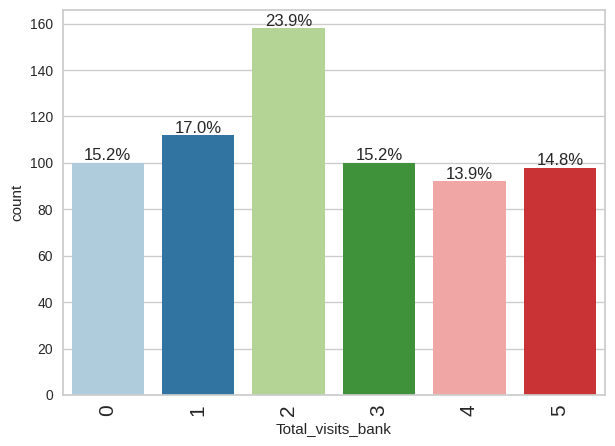

In [58]:
labeled_barplot(data_EDA, "Total_visits_bank", perc=True)

%23.9 of customers visits bank and is the highest frequency group

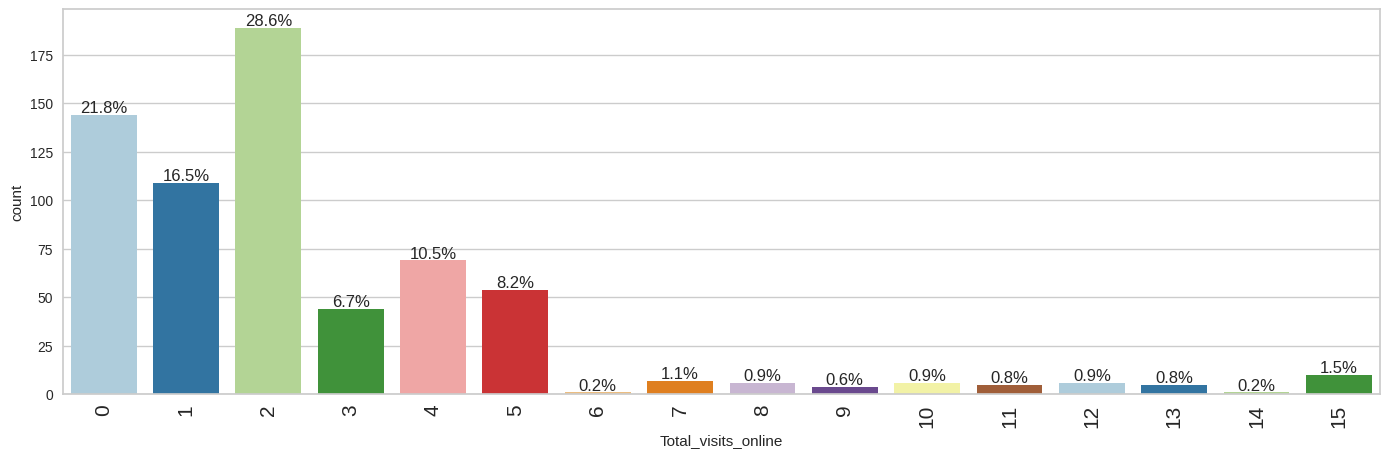

In [59]:
labeled_barplot(data_EDA, "Total_visits_online", perc=True)

%28.6 percentage of group visits 2 times with having highest frequencey

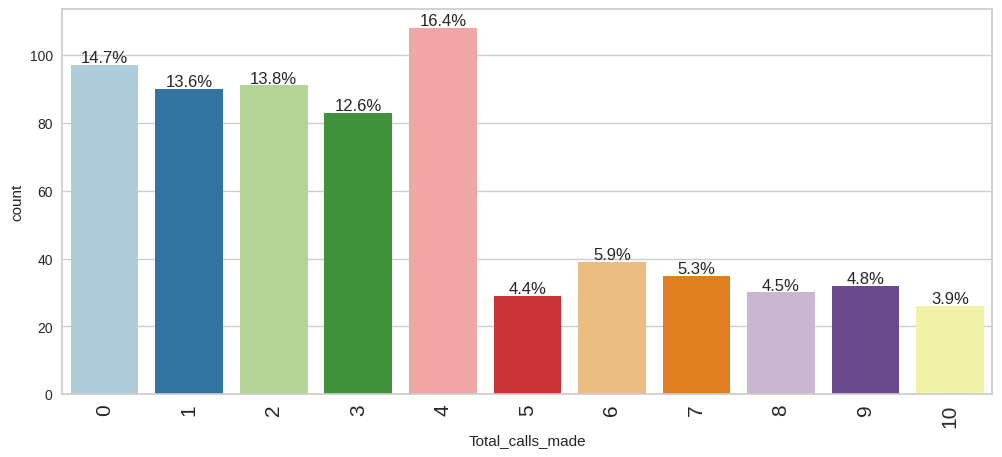

In [60]:
labeled_barplot(data_EDA, "Total_calls_made", perc=True)

Amoung total customer count with %16.4 percentage of customers having 4 calls anually to the bank

In [61]:
data_EDA.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


**Total Credit Cards Vrs Total Calls Made**

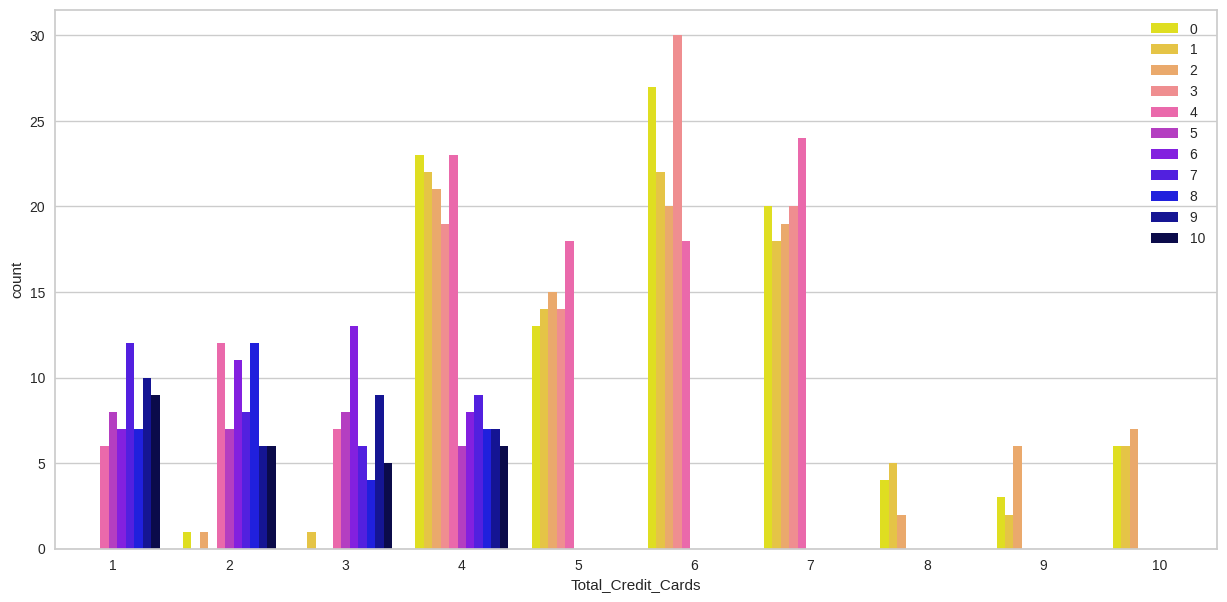

In [62]:
plt.figure(figsize=(15,7))
sns.countplot(data = data_EDA, x = data_EDA["Total_Credit_Cards"],hue=data_EDA["Total_calls_made"],palette="gnuplot2_r")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

The aim of choosing this graph to see interaction of customers based on Credit Card numbers



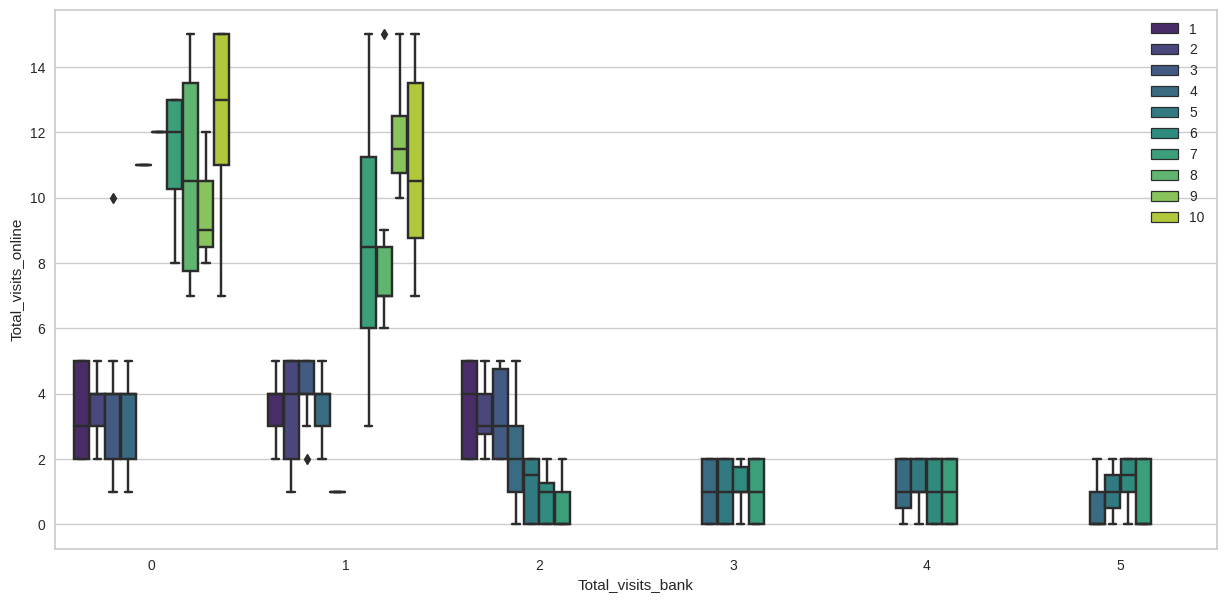

In [63]:
plt.figure(figsize=(15,7))
sns.boxplot(data = data_EDA, x = data_EDA["Total_visits_bank"], y = data_EDA["Total_visits_online"],hue=data_EDA["Total_Credit_Cards"],palette="viridis")
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

For analyzing customent interaction with bank , when card number increases customers prefers to choose visits of bank rather than online visits

##4-DATA PREPROSESSING

In [64]:
data_preprocess=data_EDA.copy()

4.1 **Imputing Missing Values :**

No missing values exits at data set

4.2 **Fixing Outliers In Data Set**

In [65]:
# functions to treat outliers by flooring and capping


def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [66]:
numerical_col=data_preprocess.select_dtypes(include=np.number).columns.tolist()

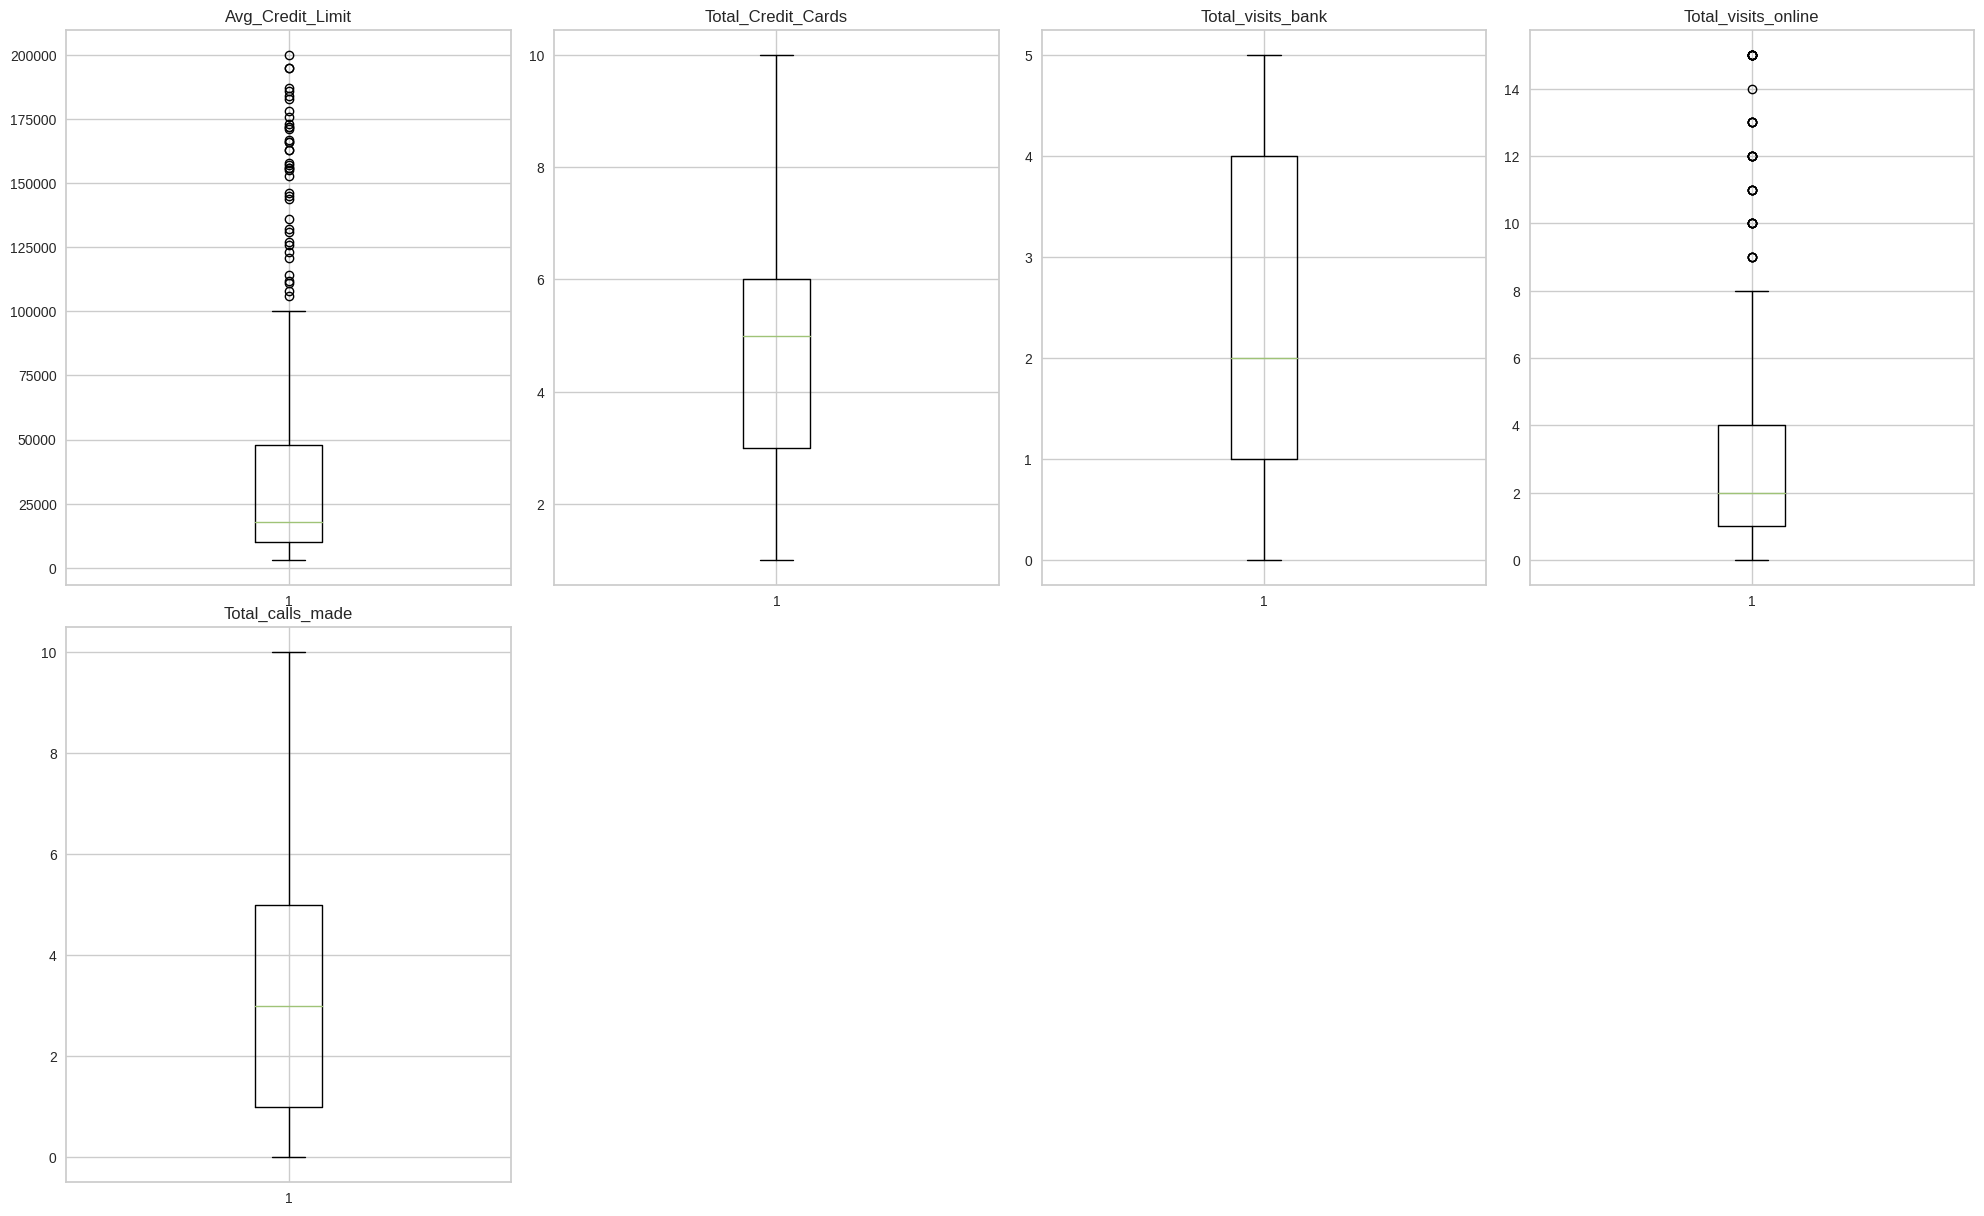

In [67]:
numerical_col = data_preprocess.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(data_preprocess[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

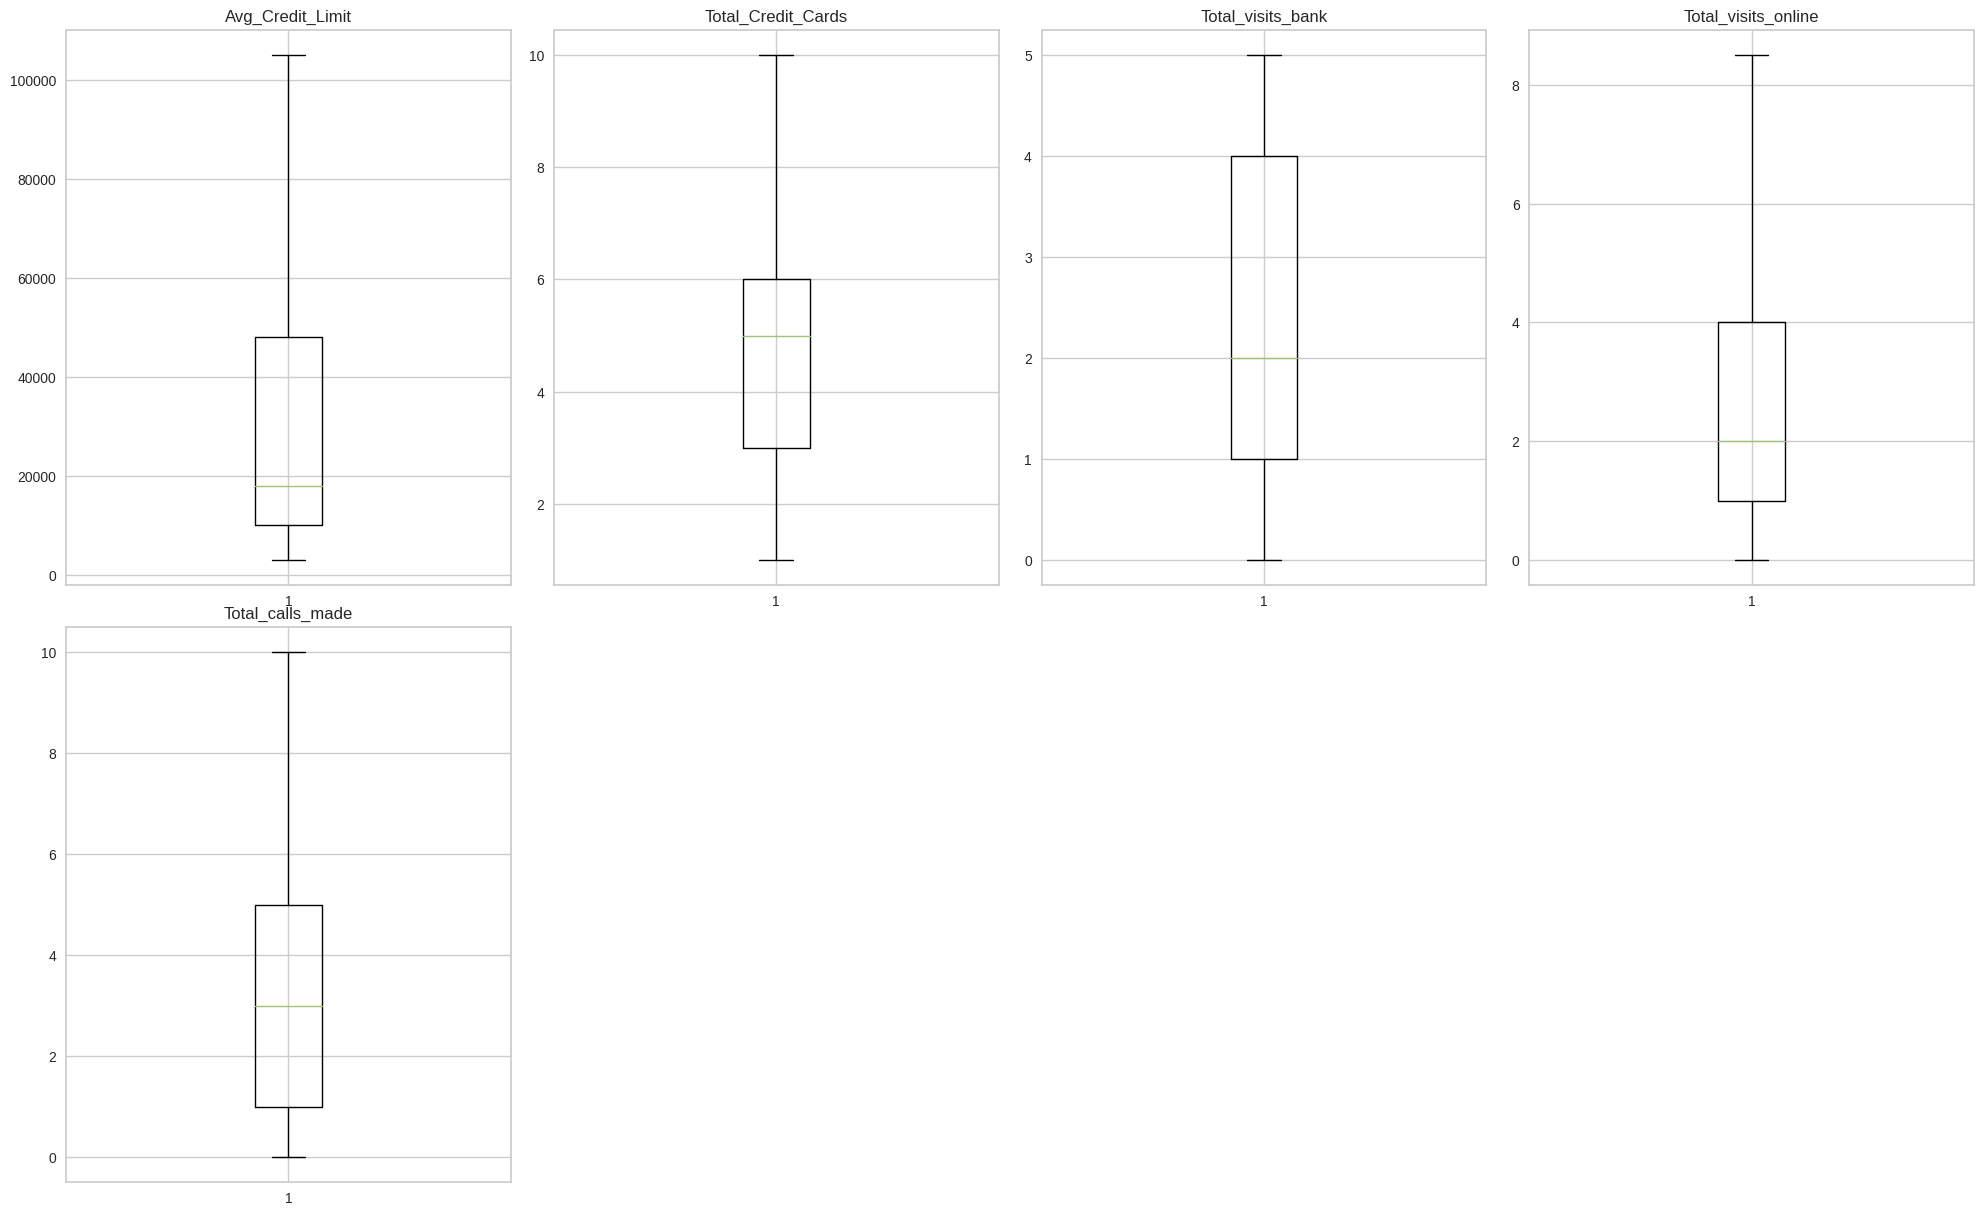

In [68]:
numerical_col = data_preprocess.select_dtypes(include=np.number).columns.tolist()
X_val = treat_outliers_all(data_preprocess, numerical_col)
# let's look at box plot to see if outliers have been treated or not
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(X_val[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

4.2 Scale Data Set 

Scaling Data is important step for unsupervised learning  process to avoid the problem of one feature dominating over others due to unsupervised learning algorithm uses distance to find the similarity between data points.

1. Data standardization is the process of rescaling the attributes so that they have a mean of 0 and a variance of 1.
2. The ultimate goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values.
3. In sklearn.preprocessing.StandardScaler(), centering and scaling happen independently on each feature.

In [69]:
data_preprocess

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1.0,0
1,50000,3,0,8.5,9
2,50000,7,1,3.0,4
3,30000,5,1,1.0,4
4,100000,6,0,8.5,3
...,...,...,...,...,...
655,99000,10,1,8.5,0
656,84000,10,1,8.5,2
657,105000,8,1,8.5,1
658,105000,10,1,8.5,0


In [70]:
sc = StandardScaler()


In [71]:
data_scaled = pd.DataFrame(
    sc.fit_transform(data_preprocess),    
)


In [72]:
data_scaled.head()

,0,1,2,3,4
0,2.398942,-1.249225,-0.860451,-0.619767,-1.251537
1,0.643619,-0.787585,-1.473731,2.705813,1.891859
2,0.643619,1.058973,-0.860451,0.267054,0.145528
3,-0.058511,0.135694,-0.860451,-0.619767,0.145528
4,2.398942,0.597334,-1.473731,2.705813,-0.203739


##5-UNSUPERVISED LEARNING METHODS

5.1 K-MEANS Clustring

Choosing up to cluster range(1,9) , matching the Euclidean distance calculation 

Data is scaled(before) since Euclidean Calculation is sensitive to outliers 

Number of Clusters: 1 	Average Distortion: 2.0731463576129583
Number of Clusters: 2 	Average Distortion: 1.4986141501796377
Number of Clusters: 3 	Average Distortion: 1.1823298853410935
Number of Clusters: 4 	Average Distortion: 1.0711026440504199
Number of Clusters: 5 	Average Distortion: 1.0048977741354532
Number of Clusters: 6 	Average Distortion: 0.9522572838350665
Number of Clusters: 7 	Average Distortion: 0.9148518604942721
Number of Clusters: 8 	Average Distortion: 0.8904674013710712


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

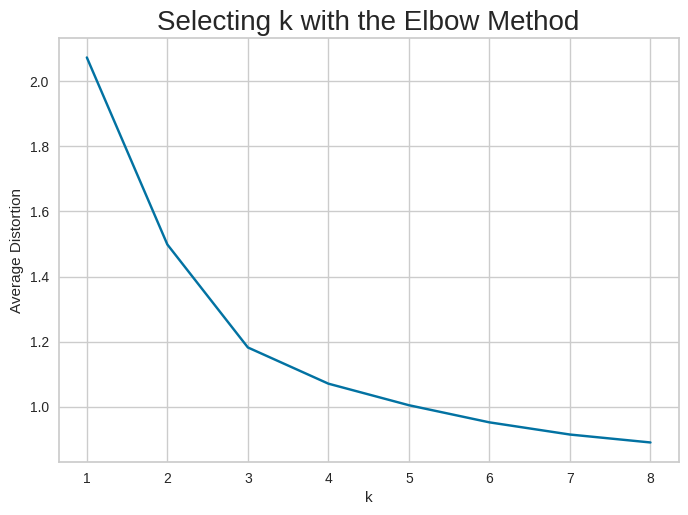

In [73]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(data_scaled)  # Fit kMeans on the data
    prediction = model.predict(data_scaled)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(data_scaled, model.cluster_centers_, "euclidean"), axis=1))
        / data_scaled.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

Observation :

**In the K with Elbow method its obvious that at cluster 2 and 3 there is a elbow curve exits . But its more obvious in cluster 3**

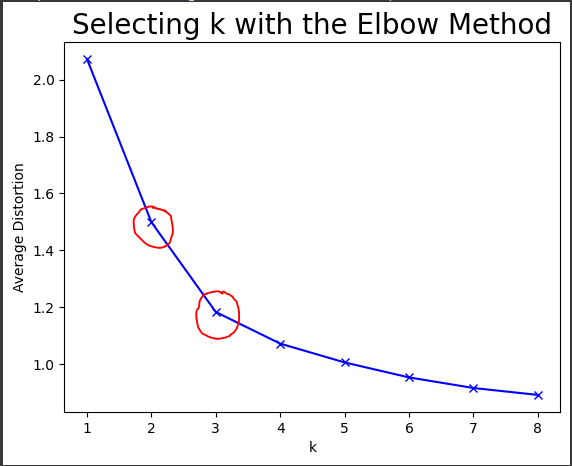


5.1.1 Calculating Silhouette Score

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. 

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. 
* Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2, silhouette score is 0.4201583924929177
For n_clusters = 3, silhouette score is 0.5169867470092899
For n_clusters = 4, silhouette score is 0.38147048130671246
For n_clusters = 5, silhouette score is 0.35332888701008774
For n_clusters = 6, silhouette score is 0.27103672505070076
For n_clusters = 7, silhouette score is 0.26743115189238703
For n_clusters = 8, silhouette score is 0.25635653275141496


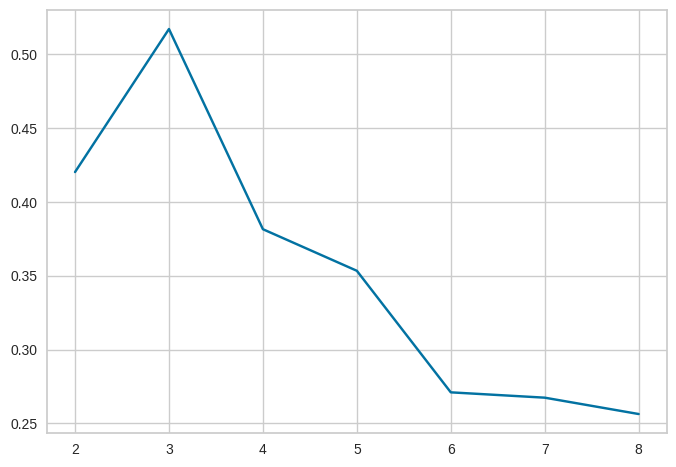

In [74]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 9))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((data_scaled))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**Observations:**

**At cluster 3** 

Disturtion = 1.1823298853410935

Silhouette score is 0.5169867470092899

This shows that 3 is optimum number of clusters having more well seperated  than the others

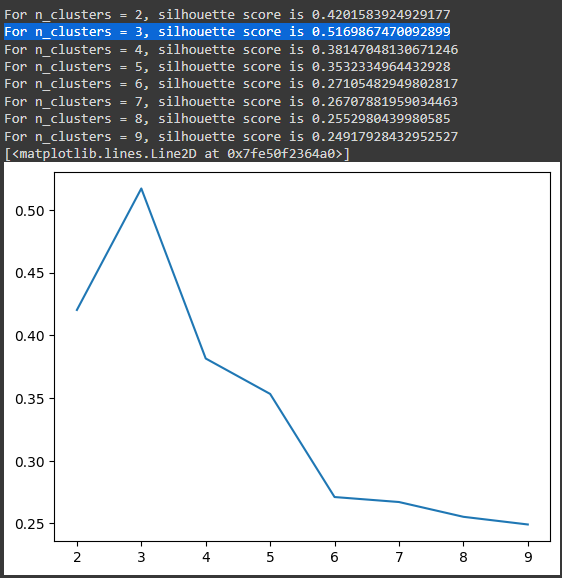

5.1.2 Score SilhouetteVisualizer

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score
  
**Note** 
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score. 

**5.1.2.1 Checking Silhouette Visualizer For 2 Clusters**

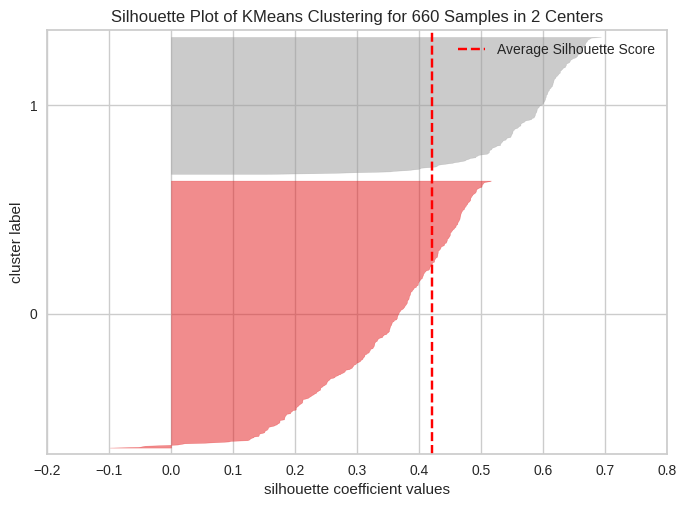

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [75]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obesrvations for 2 clusters:

There is negative silhouette coefficent value -           **FAILED** 

All the clusters passing cross the avg silhouette score   **PASSED**

All the clusters have the different variations (width)    **PASSED**

All the clusters should have different silhouette score   **PASSED**






**5.1.2.2 Checking Silhouette Visualizer For 3 Clusters**

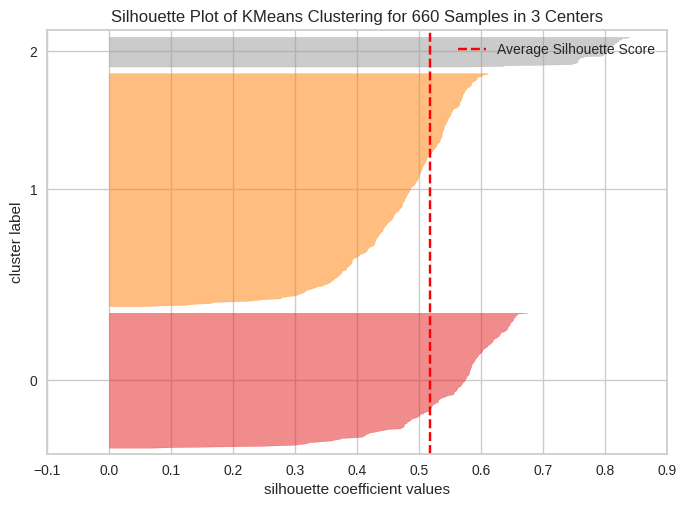

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [76]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Observations



Obsorvations for 3 clusters:

There is negative silhouette coefficent value -           **PASSED** 

All the clusters passing cross the avg silhouette score   **PASSED**

All the clusters have the different variations (width)    **PASSED**

All the clusters should have different silhouette score   **PASSED**

***So it passes of all testing***

**5.1.2.3 Checking Silhouette Visualizer For 4 Clusters**

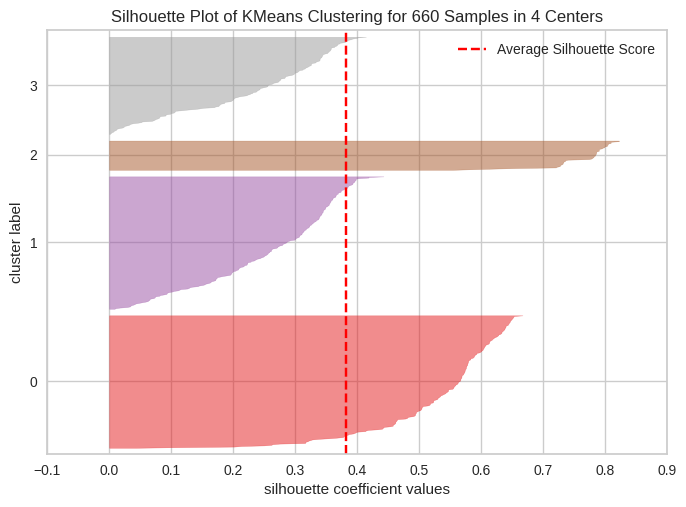

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [77]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 4 clusters:

There is negative silhouette coefficent value -                     **PASSED** 

All the clusters slightly passing cross the avg silhouette score    **FAILED**

All the clusters have the different variations (width) 0,1 nearly same size                  **FAILED**

All the clusters should have different silhouette score             **PASSED**



**5.1.2.4 Checking Silhouette Visualizer For 5 Clusters**

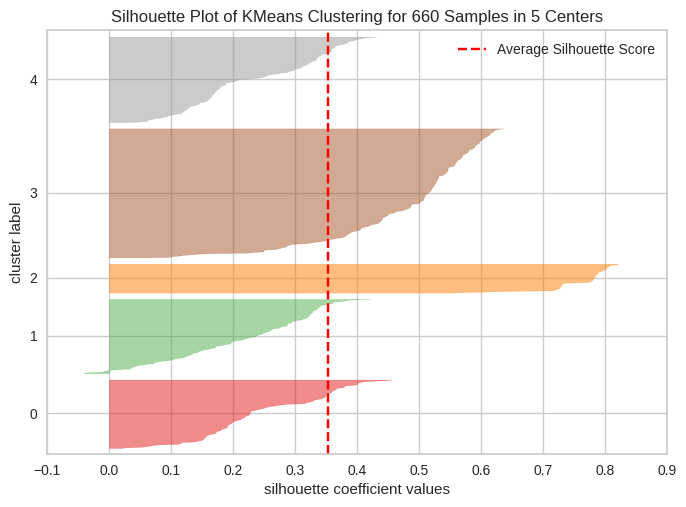

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [78]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 5 clusters:

There is negative silhouette coefficent value -                     **FAILED** 

All the clusters slightly passing cross the avg silhouette score    **PASSED**

All the clusters have the different variations (width) size                **PASSED**

All the clusters should have different silhouette score             **PASSED**



**5.1.2.5 Checking Silhouette Visualizer For 6 Clusters**





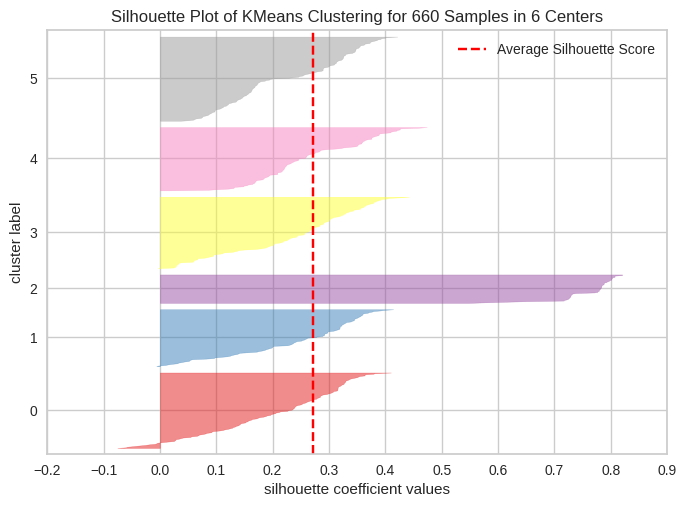

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [79]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 6 clusters:

There is negative silhouette coefficent value -                     **FAILED** 

All the clusters slightly passing cross the avg silhouette score    **PASSED**

All the clusters have the different variations (width) size                **PASSED**

All the clusters should have different silhouette score             **PASSED**

**5.1.2.6 Checking Silhouette Visualizer For 7 Clusters**

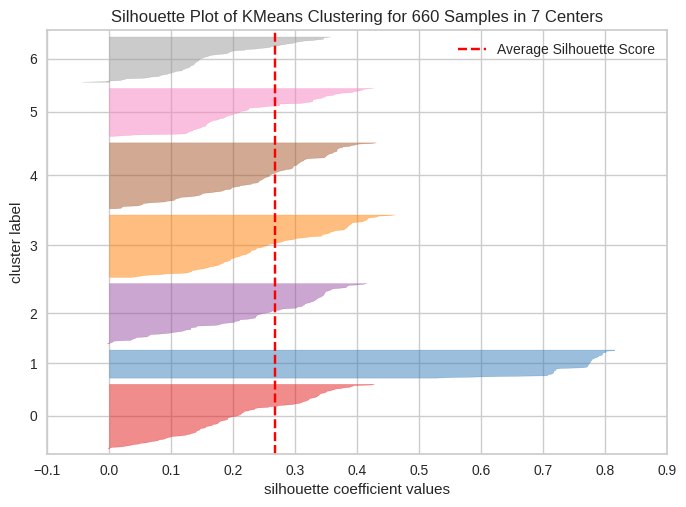

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [80]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 7 clusters:

There is negative silhouette coefficent value -                     **FAILED** 

All the clusters slightly passing cross the avg silhouette score    **PASSED**

All the clusters have the different variations (width) size                **FAILED**

All the clusters should have different silhouette score             **PASSED**

**5.1.2.7 Checking Silhouette Visualizer For 8 Clusters**

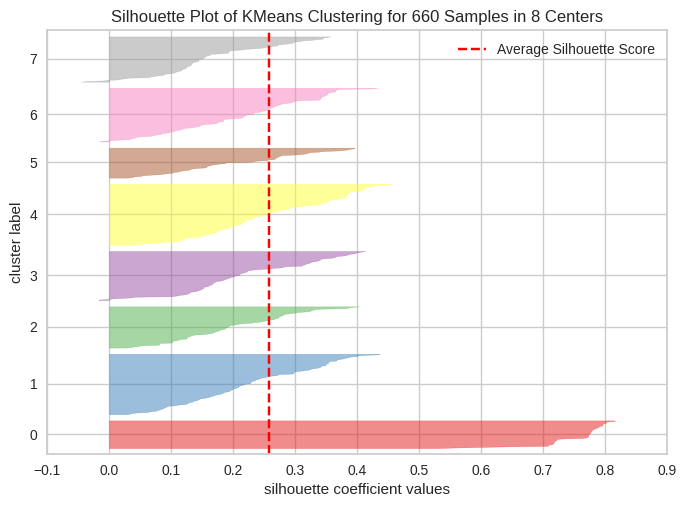

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [81]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 8 clusters:

There is negative silhouette coefficent value -                     **FAILED** 

All the clusters slightly passing cross the avg silhouette score    **PASSED**

All the clusters have the different variations (width) size                **FAILED**

All the clusters should have different silhouette score             **PASSED**

**5.1.2.8 Checking Silhouette Visualizer For 9 Clusters**

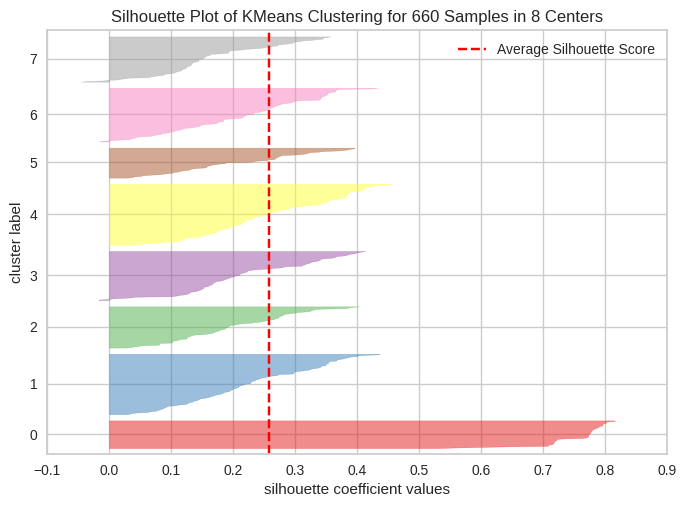

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [82]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Obsorvations for 9 clusters:

There is negative silhouette coefficent value -                     **FAILED** 

All the clusters slightly passing cross the avg silhouette score    **PASSED** 

All the clusters have the different variations (width) size                **FAILED**

All the clusters should have different silhouette score             **PASSED**

**5.1.3 Appliying K Means For 3 Clusters**

In [83]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=1)

In [84]:
data_K_Means=data_EDA.copy()

In [85]:
data_K_Means["K_means_segments"]=kmeans.labels_

**5.1.4 Cluster Profiling**

In [86]:
# adding kmeans cluster labels to the original dataframe
cluster_profile_k_means = data_K_Means.groupby("K_means_segments").mean()

In [87]:
# let's display cluster profiles
cluster_profile_k_means.style.highlight_max(color="red", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536
1,33782.383420,5.515544,3.489637,0.981865,2.000000
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [88]:
num_col=["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

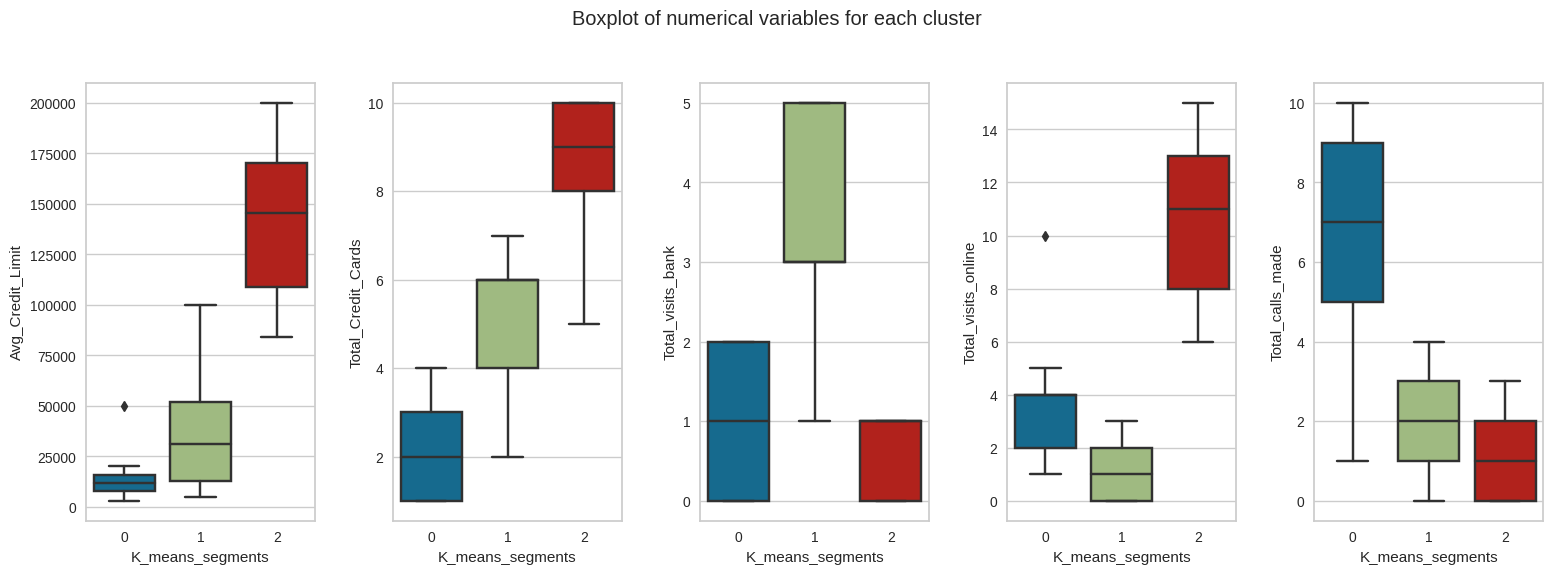

In [89]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data_K_Means[num_col[counter]], x=data_K_Means["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**5.1.5 Observations**

`Cluster 0 Customers` : 

In this cluster Avg Credit Limit and Credit card numbers are less than the other groups but generating high calls based on opeartional stuff. 

Marketing Perspective:

This group can be a good target for marketing group to sell credit cards also improving customers credit limit. Size of credit card limit may not be offered as high as the other groups (assuming they have a limited annual income) but they can good target to sell new credit cards.

Campaigns can be organized based on giving new credit cards to this group.

Operational Perpective:

This gorup shows less interaction on Online rather than choosing calling to bank. For this group of customers Online services can be promoted in call center services to decrease operational expences.

`Cluster 1 Customers` : 

These customer segment is mid segment between 0 and 2 clusters based on Credit Card Numbers and Avreage Credit Limit. 

Marketing Perspective:

They are using multiple different credit cards and they can be good candidates for replacing their existing cards with new Alllife Bank cards . They can be offered with different campaigns for high limit cards to position well AllLife bank in copetition.  

Operation Perspective:

They are highly visiting bank not using online services rather than the other groups. These segment of customers can be directed to online or call center services to decrease opex costs in bank branches.


`Cluster 2 Customers` : 

These customer segment is the highest Average Credit Limit and Card numbered customers. 

Marketing Perspective: 

To compete for this cluster exclusive services can be campaigned and high credit range credit cards can be offered.

Operational Perspective:

Operational team take care of this customer segment for the quality of the service. These type of customers are generally using online services rather than calls and visits to bank. Internet/Mobile bank services innovations can be campaigned first to these customers from the bank operation team.



5.2 **Hierarchical Clustering and PCA**

5.2.1 Cophenetic Correlation

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. 

It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. 

That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms.

In [90]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.6666982080229052.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8207884321476555.
Cophenetic correlation for Euclidean distance and average linkage is 0.8926672966587861.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8872365340578665.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6882876568342585.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7672199195985938.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8907216945489854.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.782728724334691.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.658393428048562.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.388494379210295.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7998609088477292.
Cophenetic corre

In [91]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8926672966587861, which is obtained with Euclidean distance and average linkage.


In [92]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(data_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(data_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.6666982080229052.
Cophenetic correlation for complete linkage is 0.8207884321476555.
Cophenetic correlation for average linkage is 0.8926672966587861.
Cophenetic correlation for centroid linkage is 0.8880634847869346.
Cophenetic correlation for ward linkage is 0.7702265240776373.
Cophenetic correlation for weighted linkage is 0.8872365340578665.


In [93]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8926672966587861, which is obtained with average linkage.


5.2.2 Cophenetic Correlation On Dendogram

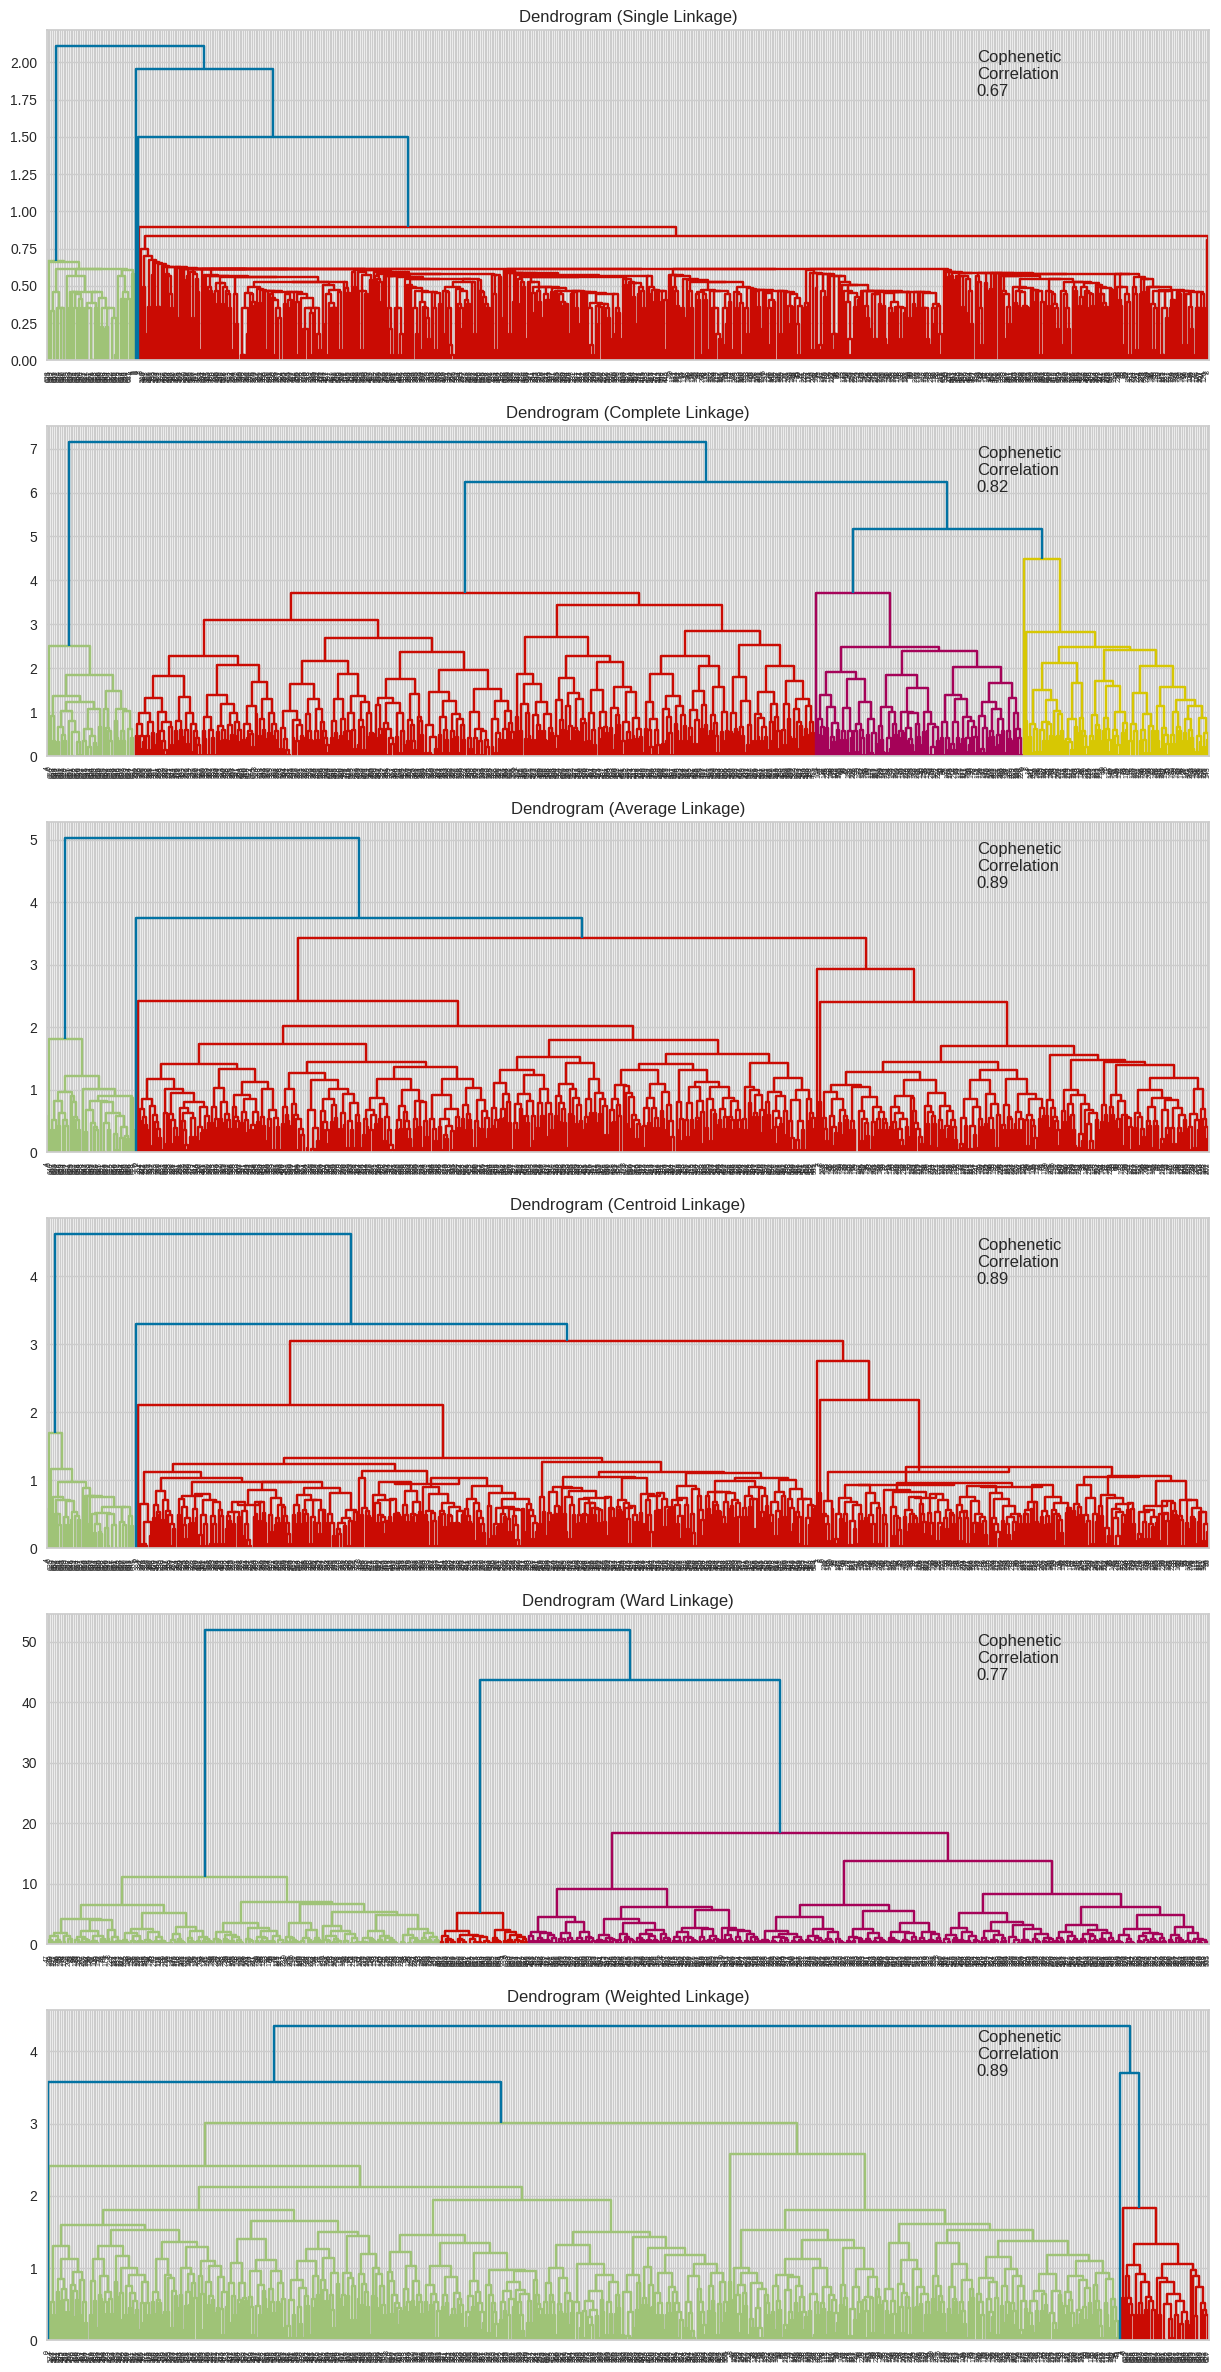

In [94]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )




Observations:

Highest Cophenetic Correlation got from Average Linkage:0.89 with Eucledean Distance but Clusters is not well seperated in Average Linkage .

Complete Linkage has also high Cophenetic Correlation:0.82 with Eucledean Distance calculation. And clusters well seperated rather than other linkage methods.

I will choose  4 main clusters based on complete linkege

**5.2.3 Agglomerative Clustering With Complete Linkage with Affinity Euclidean With 4 Clusters** 

In [95]:
HCmodel_complete = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="complete")
HCmodel_complete.fit(data_scaled)

AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

**5.2.3.1 Cluster Profiling Complete Linkage with Affinity Euclidean With 4 Clusters**


In [96]:
data_hier_clustering_complete=data.copy()

In [97]:
datascaled_hier_clustering_complete=data_scaled.copy()

In [98]:
datascaled_hier_clustering_complete["HC_Clusters"] = HCmodel_complete.labels_


In [99]:
data_hier_clustering_complete["HC_Clusters"] = HCmodel_complete.labels_

In [100]:
data_hier_clustering_complete

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,1
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,2
4,5,47437,100000,6,0,12,3,3
...,...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0,3
656,657,60732,84000,10,1,13,2,3
657,658,53834,145000,8,1,9,1,3
658,659,80655,172000,10,1,15,0,3


In [101]:
cluster_profile_complete = data_hier_clustering_complete.groupby("HC_Clusters").mean()

In [102]:
cluster_profile_complete["count_in_each_segments"] = (
    data_hier_clustering_complete.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

In [103]:
# let's see the names of the countries in each cluster
for cl in data_hier_clustering_complete["HC_Clusters"].unique():
    print("In cluster {}, Customers are :".format(cl))
    print(data_hier_clustering_complete[data_hier_clustering_complete["HC_Clusters"] == cl]["Customer Key"].unique())
    print()

In cluster 0, Customers are :
[87073 58634 37376 82490 44770 52741 52326 25084 68517 62617 96463 29794
 61061 81130 29112 13999 61517 30888 74126 52363 50769 68502 83326 37252
 74625 60301 68419 32828 70248 91673 60403 85868 76205 35149 27120 18821
 71881 38970 57990 79694 79403 47296 37559 18007 37016 74704 11937 52736
 18916 92501 14946 73435 84069 18086 33369 35256 89007 16577 81116 36111
 11602 61627 34103 45583 52750 53898 66200 61347 37802 95489 85707 97951
 54785 35103 63751 78473 80457 64241 97536 33110 28842 38261 20524 37671
 41787 11412 55892 76718 98969 53851 52783 48510 97463 14398 15546 33317
 99596 72430 16676 44226 94251 18609 54477 12122 73811 61234]

In cluster 1, Customers are :
[38414 92503 55196 39137 14309 87241 30507 24001 68067 65034 14854 32550
 82164 28254 46388 52142 37659 83132 20119 99026 62040 51182 96386 43886
 78503 17937 71632 81566 29759 36929 61355 66524 69214 21976 33187 93482
 90168 59656 12026 99589 39447 38165 49198 59619 91099 25742 88338 96213
 

In [104]:
cluster_profile_complete.drop("Sl_No", axis=1, inplace=True)

In [105]:
cluster_profile_complete.drop("Customer Key", axis=1, inplace=True)

In [106]:
# lets display cluster profile
cluster_profile_complete.style.highlight_max(color="red", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,12849.056604,2.575472,0.858491,3.339623,5.216981,106
1,12355.932203,2.245763,0.991525,3.737288,8.322034,118
2,33541.450777,5.520725,3.492228,0.984456,2.010363,386
3,141040.000000,8.740000,0.600000,10.900000,1.080000,50


`0 Cluster and 1 Cluster is so similiar to each other`

`So i will try Ward linkage with 3 Clusters with Cophenetic Correlation =0.77`

**5.2.4 Agglomerative Clustering With Ward Linkage with Affinity Euclidean 3 Clusters**

In [107]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(data_scaled)

AgglomerativeClustering(affinity='euclidean', n_clusters=3)

**5.2.3.1 Cluster Profiling Complete Linkage with Affinity Euclidean With 4 Clusters**


In [108]:
data_hier_clustering_ward=data.copy()

In [109]:
datascaled_hier_clustering_ward=data_scaled.copy()

In [110]:
datascaled_hier_clustering_ward["HC_Clusters"] = HCmodel.labels_


In [111]:
data_hier_clustering_ward["HC_Clusters"] = HCmodel.labels_

In [112]:
data_hier_clustering_complete["HC_Clusters"] = HCmodel_complete.labels_

In [113]:
data_hier_clustering_complete

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,1
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,2
4,5,47437,100000,6,0,12,3,3
...,...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0,3
656,657,60732,84000,10,1,13,2,3
657,658,53834,145000,8,1,9,1,3
658,659,80655,172000,10,1,15,0,3


In [114]:
cluster_profile_ward = data_hier_clustering_ward.groupby("HC_Clusters").mean()

In [115]:
cluster_profile_ward["count_in_each_segments"] = (
    data_hier_clustering_ward.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

In [116]:
# let's see the names of the countries in each cluster
for cl in data_hier_clustering_ward["HC_Clusters"].unique():
    print("In cluster {}, Customers are :".format(cl))
    print(data_hier_clustering_ward[data_hier_clustering_ward["HC_Clusters"] == cl]["Customer Key"].unique())
    print()

In cluster 0, Customers are :
[87073 17341 40496 54838 35254 46635 97825 83125 35483 15129 83290 56486
 31903 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398
 32352 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328
 20072 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504
 53207 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652
 73952 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033
 85337 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878
 78002 83459 91987 51552 72156 24998 45673 11596 87485 28414 81863 33240
 11466 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437
 22610 41159 64672 62483 85614 96548 19137 69028 70779 38244 67046 64897
 46223 36628 17565 77381 11799 81940 66706 87838 94437 33790 44402 29886
 66804 47866 61996 15318 89635 71681 71862 96186 22348 36243 88807 82376
 98126 80347 17649 62807 92522 57459 44579 45476 61994 11398 24702 27824
 45878 72431 19215 23

In [117]:
cluster_profile_ward.drop("Sl_No", axis=1, inplace=True)

In [118]:
cluster_profile_ward.drop("Customer Key", axis=1, inplace=True)

In [119]:
# lets display cluster profile
cluster_profile_ward.style.highlight_max(color="red", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,12197.309417,2.403587,0.928251,3.560538,6.883408,223
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


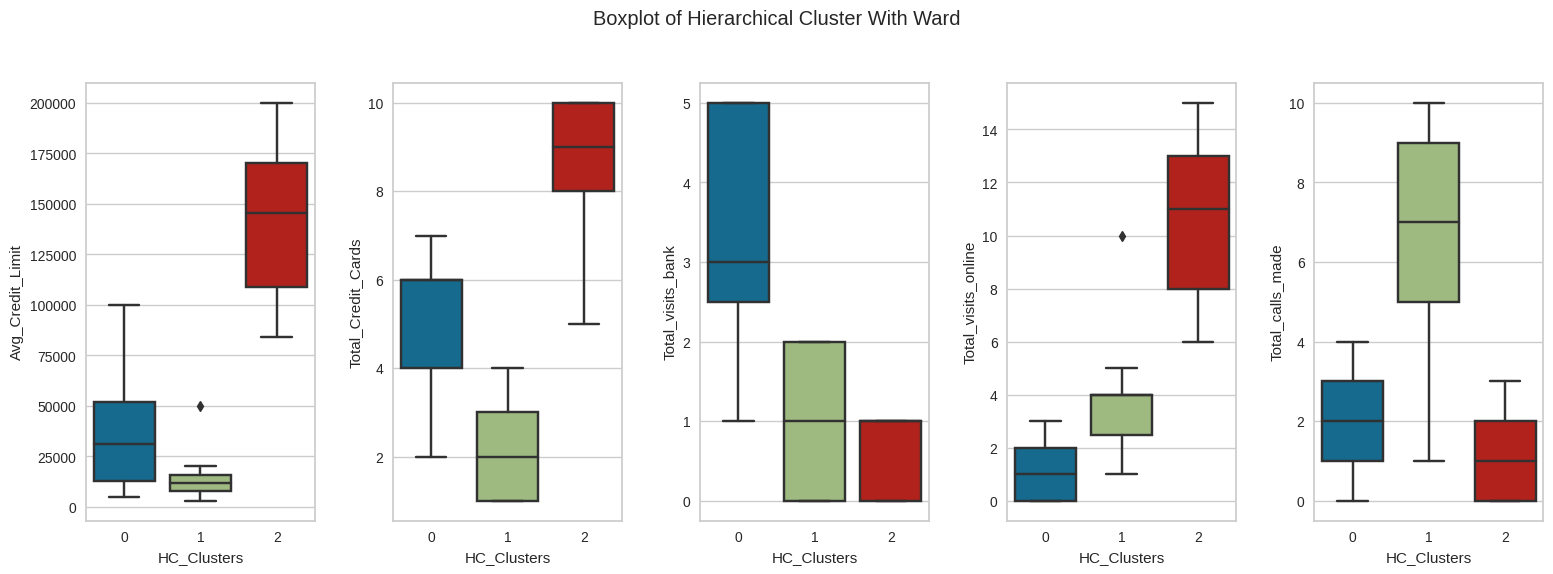

In [120]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of Hierarchical Cluster With Ward")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data_hier_clustering_ward[num_col[counter]], x=data_hier_clustering_ward["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**5.2.5 OBSERVATIONS** 

`Cluster 0 Customers` : 

These customer segment is mid segment between 1 and 2 clusters based on Credit Card Numbers and Avreage Credit Limit. 

Marketing Perspective:

They are using multiple different credit cards and they can be good candidates for replacing their existing cards with new Alllife Bank cards . They can be offered with different campaigns for high limit cards to position well AllLife bank in copetition.  

Operation Perspective:

They are highly visiting bank not using online services rather than the other groups. These segment of customers can be directed to online or call center services to decrease opex costs in bank branches.

`Cluster 1 Customers` : 

In this cluster Avg Credit Limit and Credit card numbers are less than the other groups but generating high calls based on opeartional stuff. 

Marketing Perspective:

This group can be a good target for marketing group to sell credit cards also improving customers credit limit. Size of credit card limit may not be offered as high as the other groups (assuming they have a limited annual income) but they can good target to sell new credit cards.

Campaigns can be organized based on giving new credit cards to this group.

Operational Perpective:

This gorup shows less interaction on Online rather thanand oftenly use visiting bank. For this group of customers Online services can be promoted in call center services to decrease operational expences.


`Cluster 2 Customers` : 

These customer segment is the highest Average Credit Limit and Card numbered customers. 

Marketing Perspective: 

To compete for this cluster exclusive services can be campaigned and high credit range credit cards can be offered.

Operational Perspective:

Operational team take care of this customer segment for the quality of the service. These type of customers are generally using online services rather than calls and visits to bank. Internet/Mobile bank services innovations can be campaigned first to these customers from the bank operation team.


**5.3 Dimensionality Reduction using PCA for visualization**

In [121]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 5
pca = PCA(n_components=5)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(data_scaled)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2",'Component 3','Component 4','Component 5']
)

In [122]:
pca.explained_variance_ratio_.sum()

1.0

In [123]:
pca.explained_variance_ratio_

array([0.47196473, 0.34519351, 0.06514194, 0.06213265, 0.05556717])

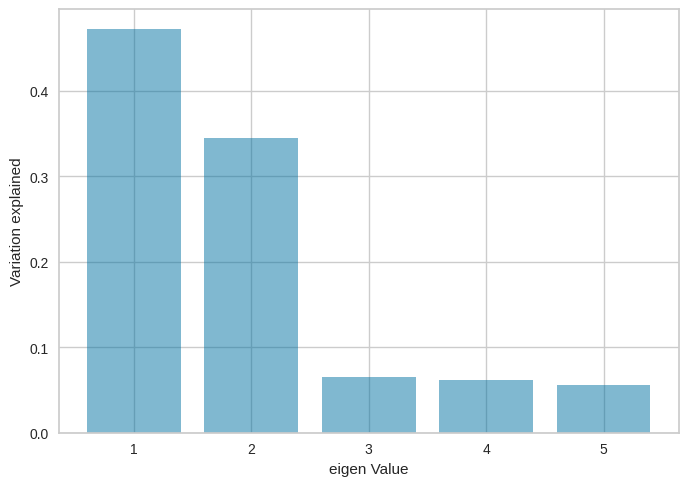

In [124]:
plt.bar(list(range(1,6)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

Component 1 (Major) and Component (2) is explaining the big %82 part of data

In [125]:
pca.components_

array([[-0.39254601, -0.54803074, -0.41919368,  0.17896576,  0.581221  ],
       [ 0.51228355,  0.24404052, -0.48344688,  0.66617718,  0.02229064],
       [ 0.38896696, -0.44176443, -0.51573145, -0.49909687, -0.37211864],
       [ 0.65451656, -0.19725328,  0.39485933, -0.16429589,  0.59143231],
       [-0.06153021,  0.63721414, -0.41068596, -0.49808473,  0.41643825]])

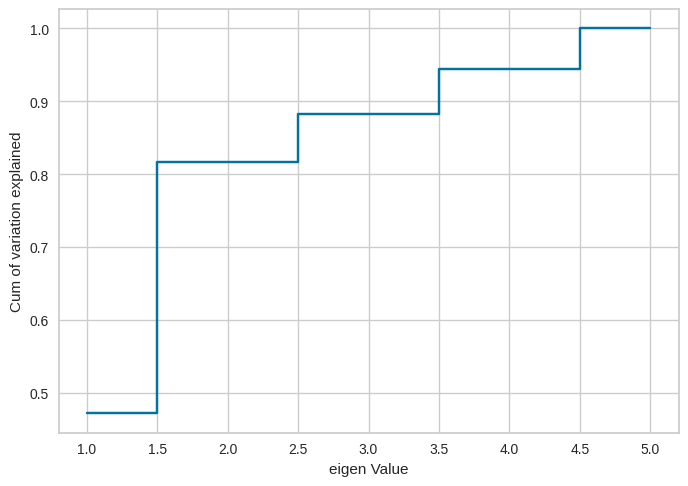

In [126]:
plt.step(list(range(1,6)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

5.3.1 Dimensionality Reduction using PCA to two components

In [127]:
pca2 = PCA(n_components=2)
pca2.fit(data_scaled)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
Xpca2 = pca2.transform(data_scaled)

[[-0.39254601 -0.54803074 -0.41919368  0.17896576  0.581221  ]
 [ 0.51228355  0.24404052 -0.48344688  0.66617718  0.02229064]]
[0.47196473 0.34519351]


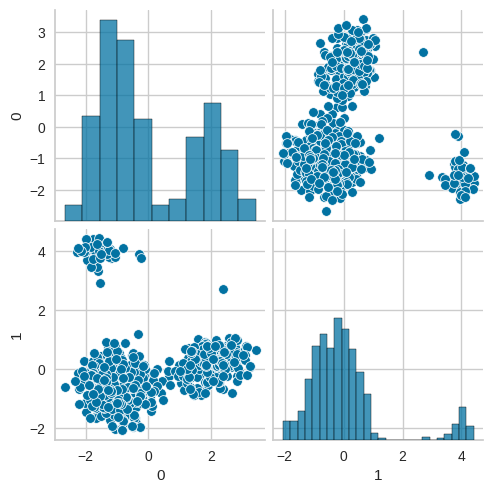

In [128]:
sns.pairplot(pd.DataFrame(Xpca2))

PCA EXPLANATION WITH 2 COMPONENTS , CLUSTERES WELL SEPERATED FROM EACH OTHER (⬇) 

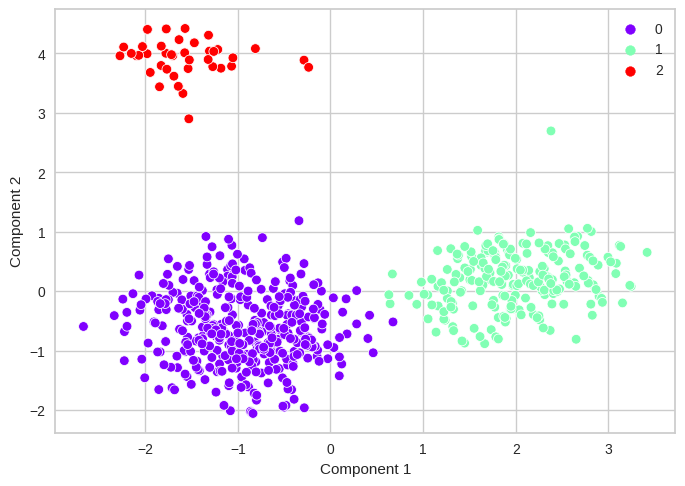

In [129]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=data_hier_clustering_ward["HC_Clusters"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

PCA Data Explation with 2 Components on Complete Linkage Clustering Data proves taht Ward Linkage (⬆) performs better than Complete Cluster Data(⬇) 

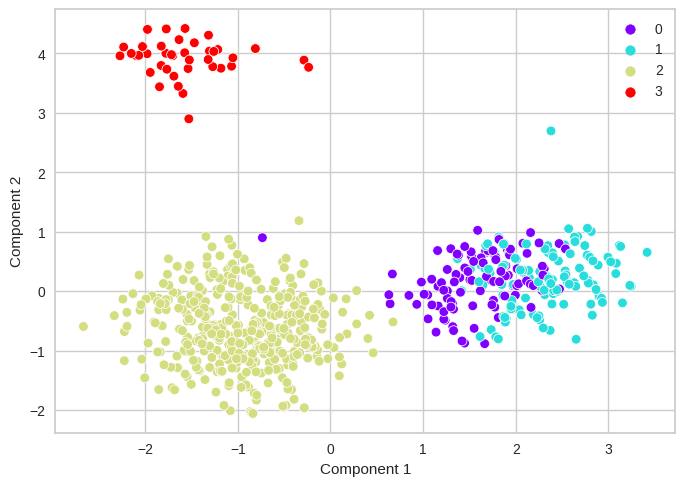

In [130]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=data_hier_clustering_complete["HC_Clusters"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

**5.4 Hierarchical Clustering Comparing(Ward Linkage Affinity Euclidean 3 Clusters) With K-Means 3 Clusters**

**5.4.1 Hierarchical Clustering(Ward Linkage- Euclidean Distance 3 Clusters) Results**

In [131]:
# lets display cluster profile
cluster_profile_ward.style.highlight_max(color="red", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,12197.309417,2.403587,0.928251,3.560538,6.883408,223
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


5.4.2 **K-Means Clustering Results**

In [132]:
cluster_profile_k_means["count_in_each_segments"] = (
    data_K_Means.groupby("K_means_segments")["Total_Credit_Cards"].count().values
)

In [133]:
cluster_profile_k_means.style.highlight_max(color="red", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [134]:
num_col=["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

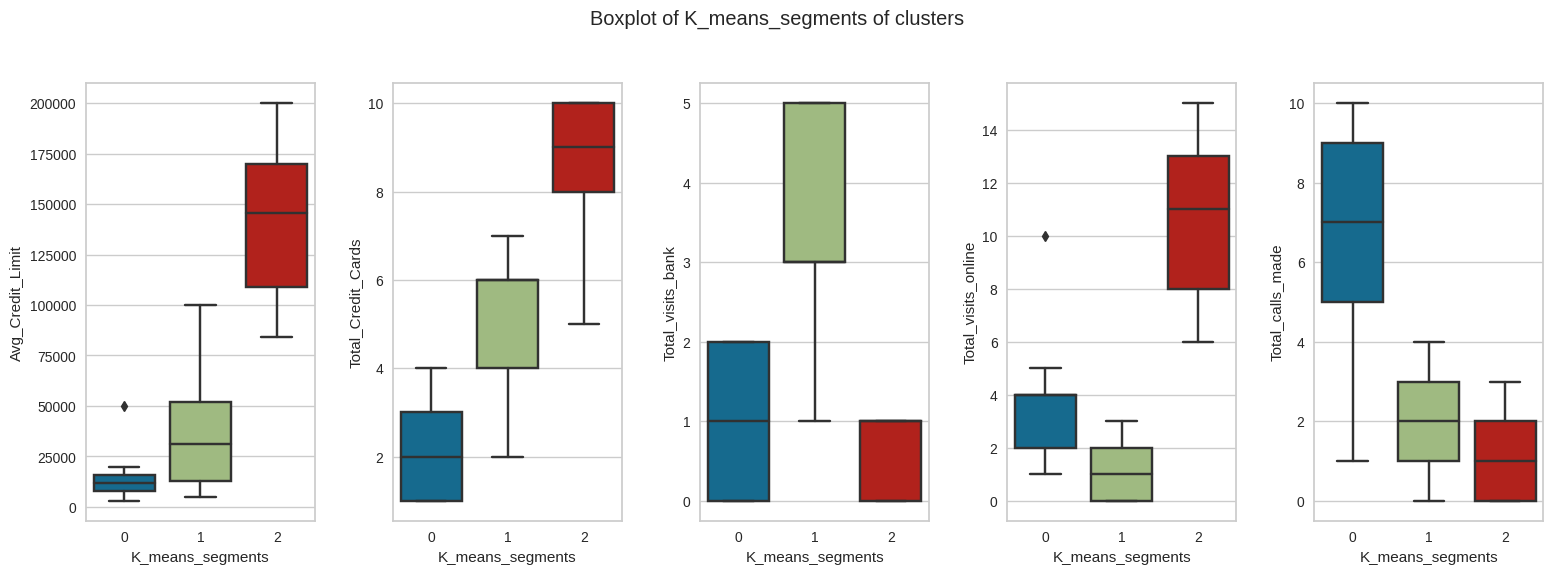

In [135]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of K_means_segments of clusters")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data_K_Means[num_col[counter]], x=data_K_Means["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

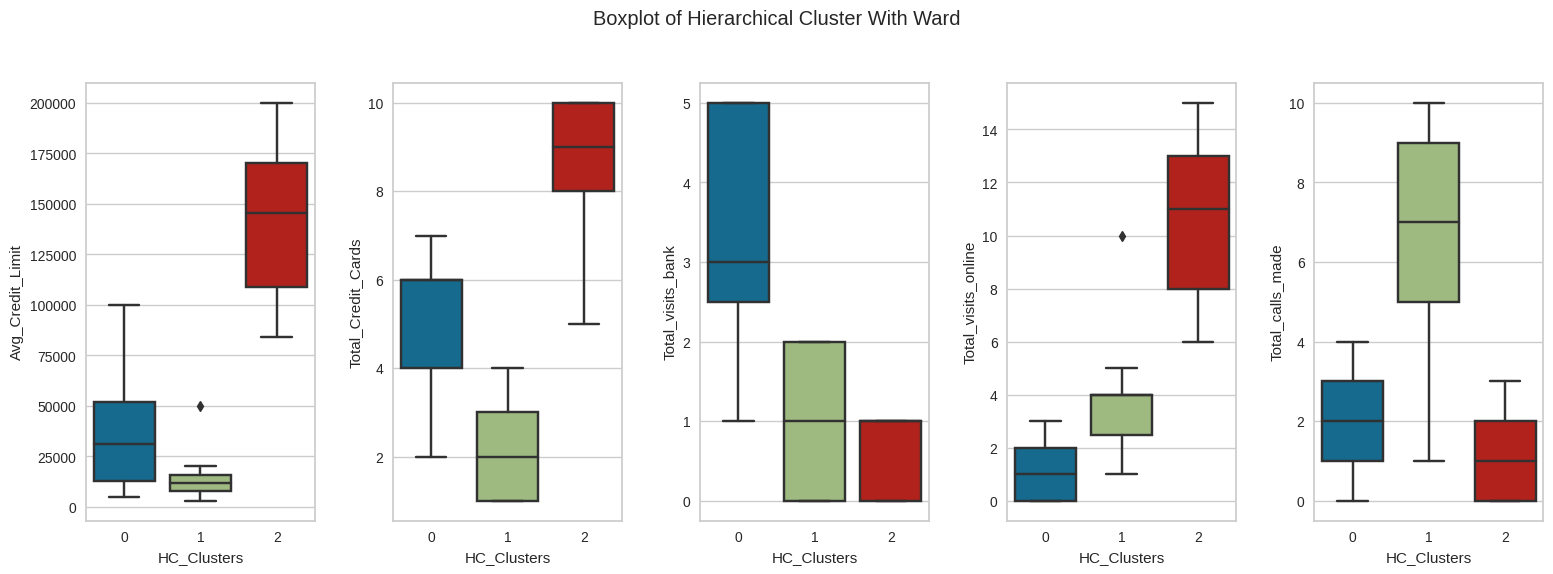

In [136]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of Hierarchical Cluster With Ward")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data_hier_clustering_ward[num_col[counter]], x=data_hier_clustering_ward["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)